
# 🧪 EXAMEN PARCIAL — *Data Mining Tools*  
**Universidad Peruana de Ciencias Aplicadas (UPC)**  
**Escuela Profesional de Ciencias de la Computación**

**Duración:** 4 horas  
**Formato de entrega:** Jupyter Notebook  
**Nombre del archivo:** `EA2_<codigo_alumno>.ipynb`  
**Puntaje total:** 20 puntos

## Objetivo general
Desarrollar un flujo completo de minería de datos aplicado a **regresión**, que incluya:  
1) **EDA automatizado**, 2) **pipelines** de imputación y escalado,  
3) **modelado de regresión**, y 4) **optimización de hiperparámetros con Optuna**;  
priorizando **interpretación detallada** y **documentación clara del código**.



## Dataset
**House Prices — Advanced Regression Techniques (Kaggle)**  
📎 **URL:** https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

El objetivo es predecir **`SalePrice`** a partir de características de la vivienda.  
Existen **valores faltantes** en múltiples columnas (p. ej., `LotFrontage`, `MasVnrType`, `MasVnrArea`, `BsmtQual`, `BsmtExposure`, `GarageType`, `GarageYrBlt`, `Electrical`).

> Descarga `train.csv` desde el enlace anterior y colócalo en la misma carpeta del notebook.  
> Utiliza únicamente `train.csv` para este examen.


## 0) Configuración e Imports

In [1]:

# =====================
# Configuración general
# =====================
import os, sys, warnings, pathlib, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

#EDA
import sweetviz as sv

## 1) Carga de datos

In [9]:
!unzip -o house.zip -d house_data 

Archive:  house.zip
  inflating: house_data/data_description.txt  
  inflating: house_data/sample_submission.csv  
  inflating: house_data/test.csv     
  inflating: house_data/train.csv    


In [3]:
df = pd.read_csv('house_data/train.csv')
df_test = pd.read_csv('house_data/test.csv')

print(f"Train data shape: {df.shape}")
print(f"Test data shape: {df_test.shape}")

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [4]:
df.memory_usage(deep=True).sum() / 1024**2 


3.434030532836914

In [5]:
df_test.memory_usage(deep=True).sum() / 1024**2


3.4193191528320312

Los dataframes juntos ocupan casi 7 MB en memoria.

No son necesarias tecnicas adicionales para la carga de datos. 



# Parte A — EDA Automatizado (5 pts)

**Instrucciones**  
- Realiza un **EDA automatizado usando una librería de tu elección** (no se prescribe una específica).  
- Identifica tipos de variables, valores faltantes, distribuciones y relaciones preliminares con `SalePrice`.  
- Selecciona **tres columnas** (una numérica, una categórica y `SalePrice`) y para **cada una** describe:  
  1) distribución, sesgo y outliers,  
  2) % de faltantes y posible mecanismo (MCAR/MAR/MNAR, si aplica),  
  3) relación preliminar con `SalePrice` (correlaciones/boxplots/cruces).

> **Interpretación esperada:** redacción clara (mín. 10 líneas) con hallazgos clave y sus implicancias para el preprocesamiento.


In [ ]:
# NO DESCOMENTAR ESTO HASTA LA SECCIÓN DE EDA, NI USAR
# report = sv.analyze(df, target_feat='SalePrice')
# report.show_html('sweetviz_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



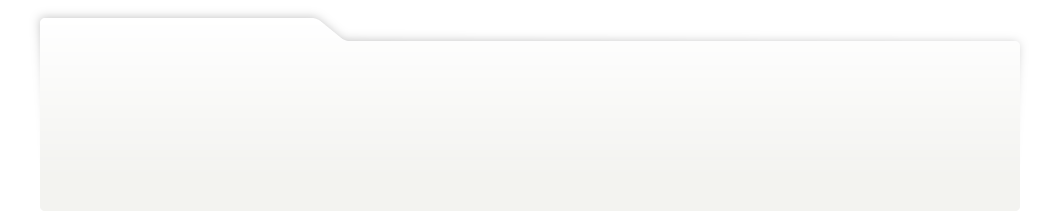
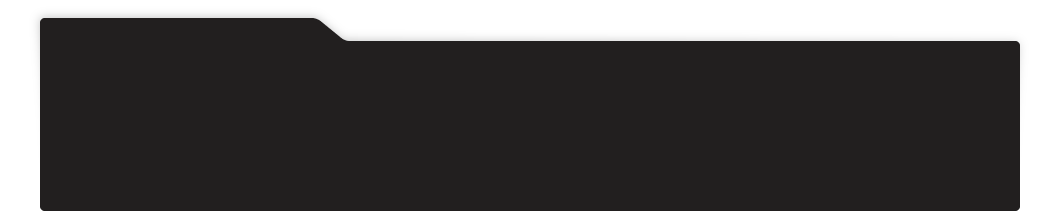
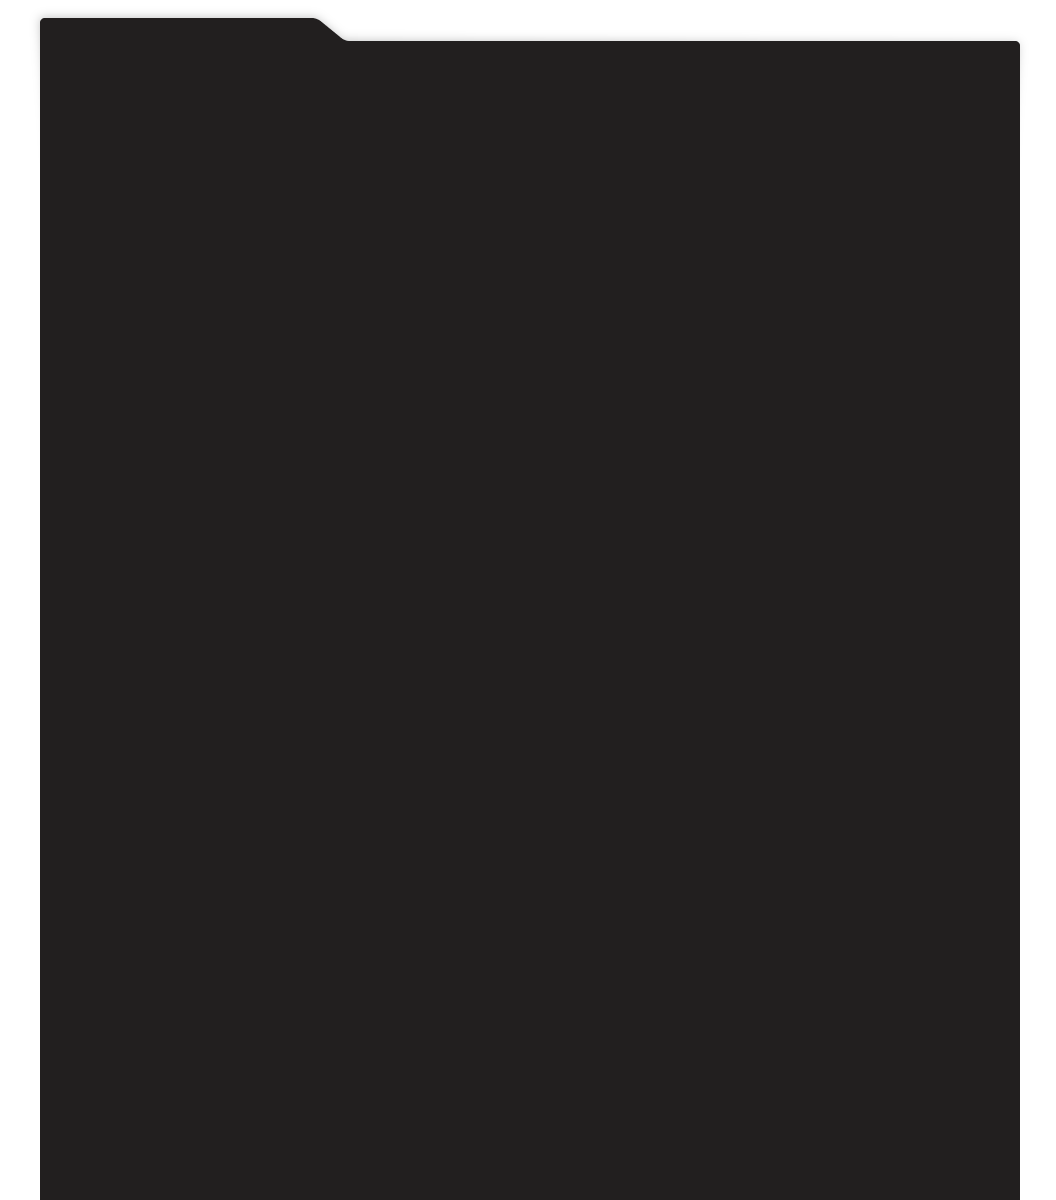
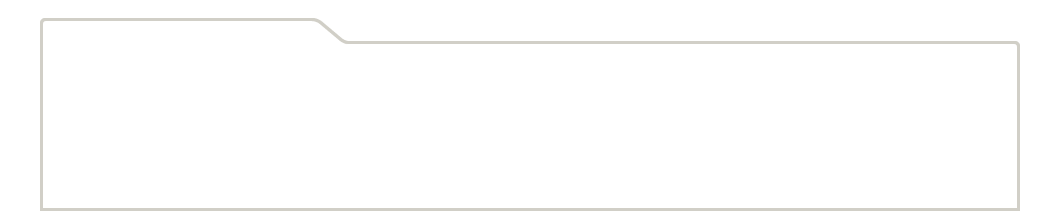
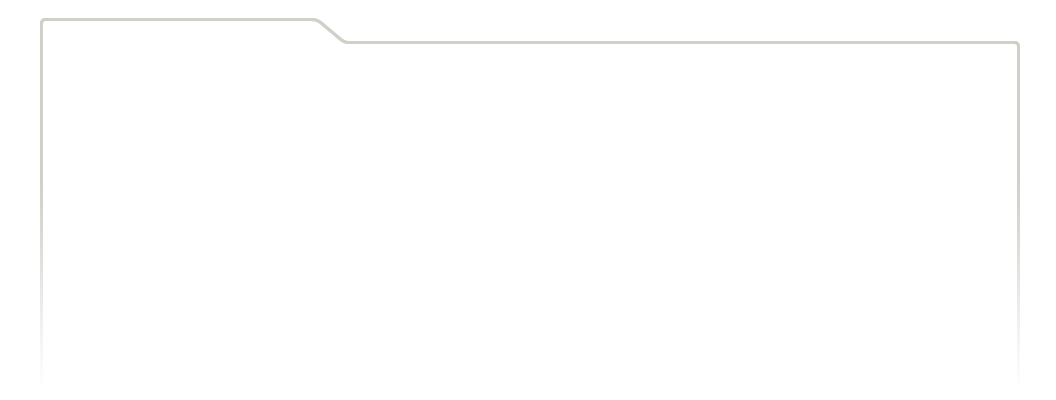
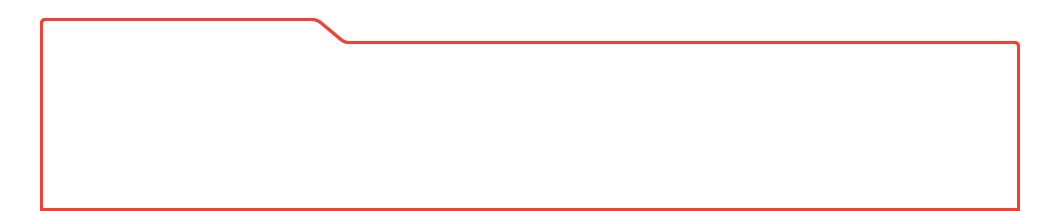
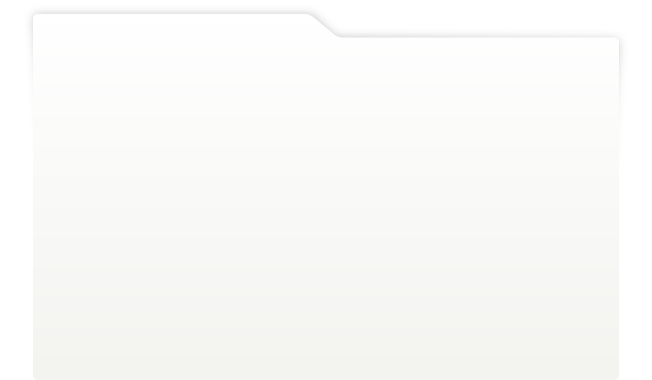
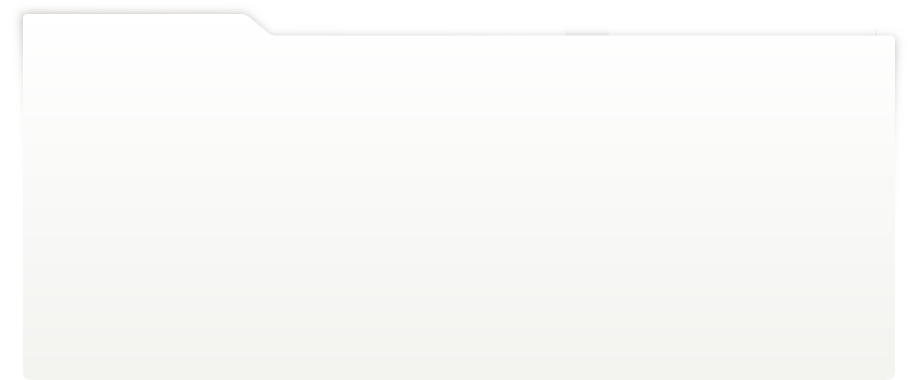
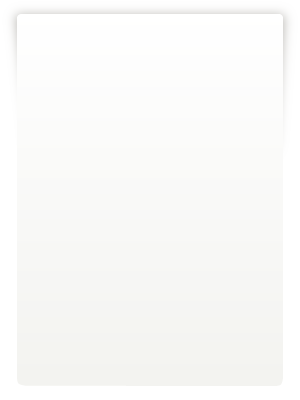
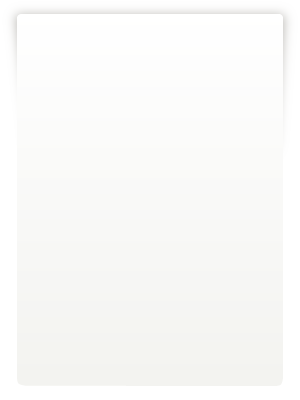
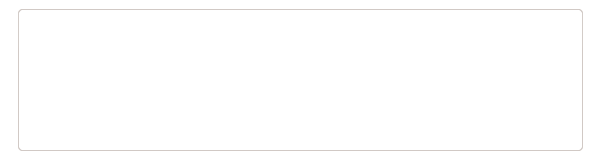
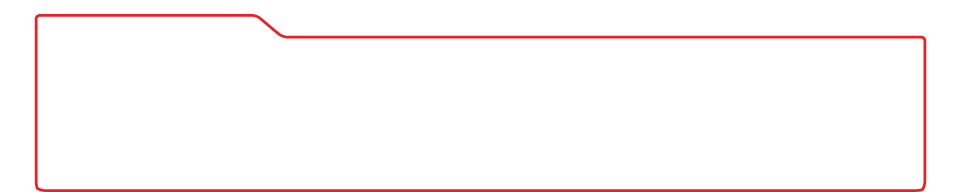
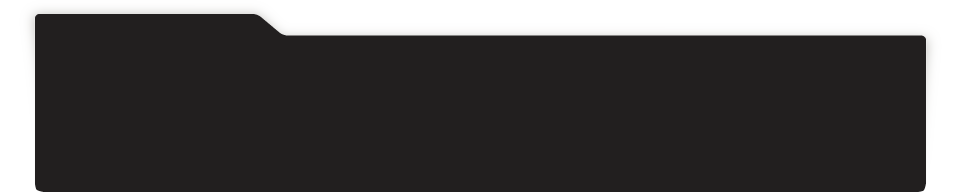
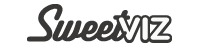
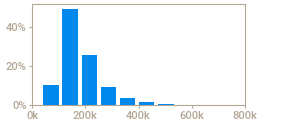
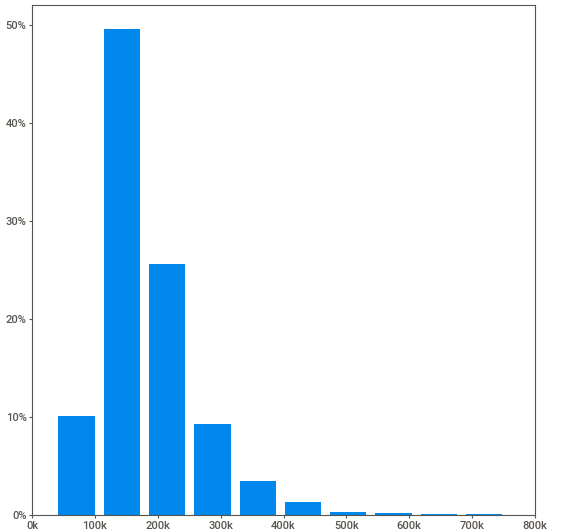
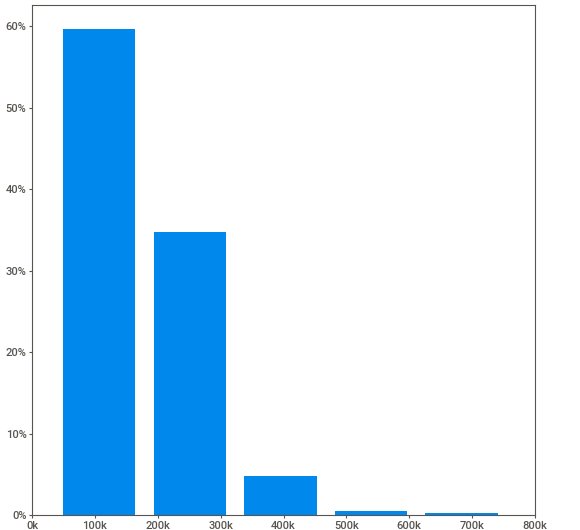
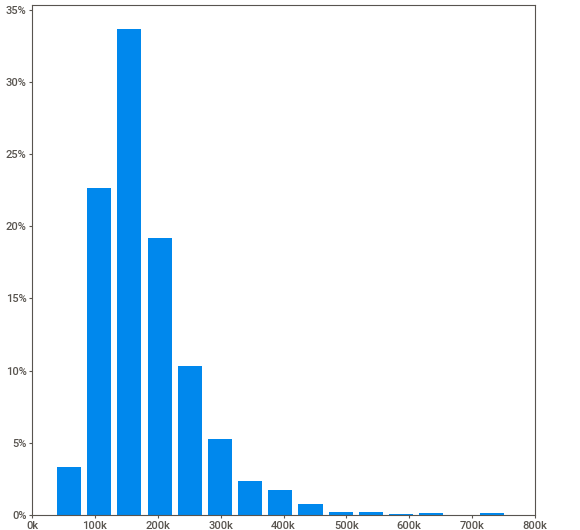
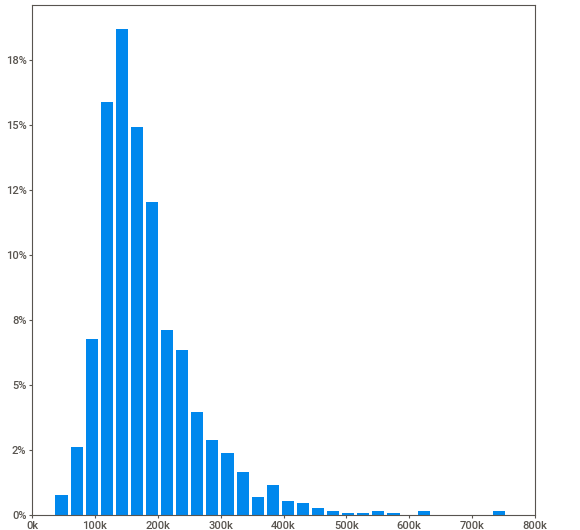
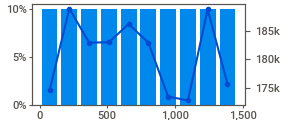
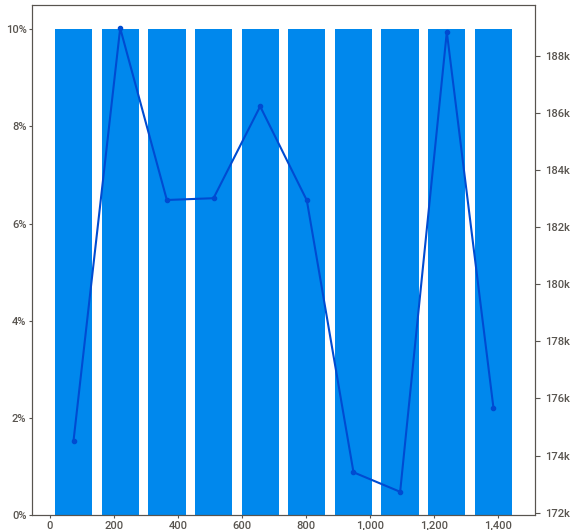
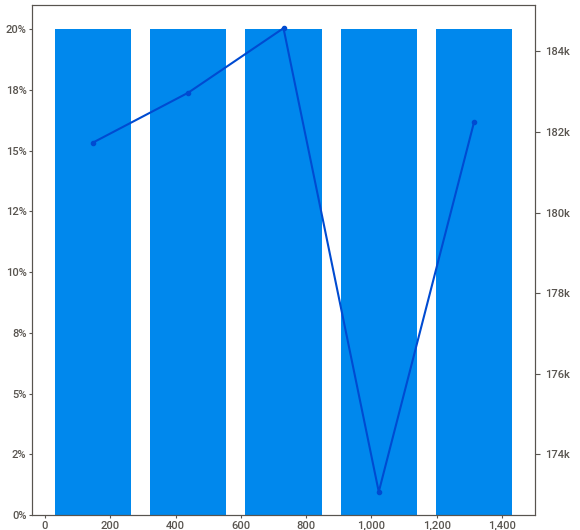
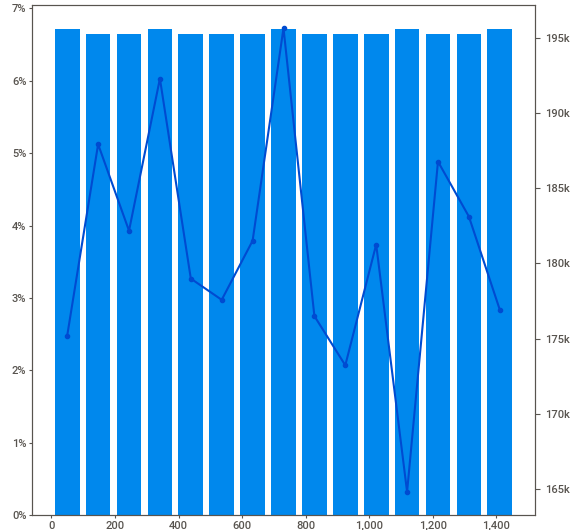
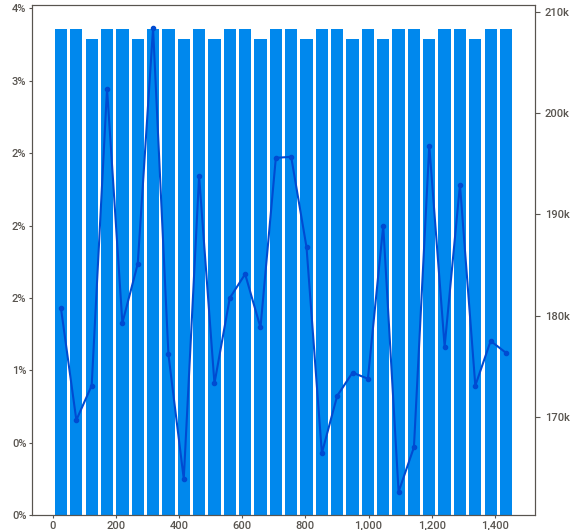
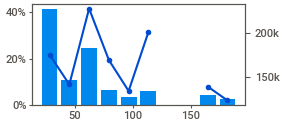
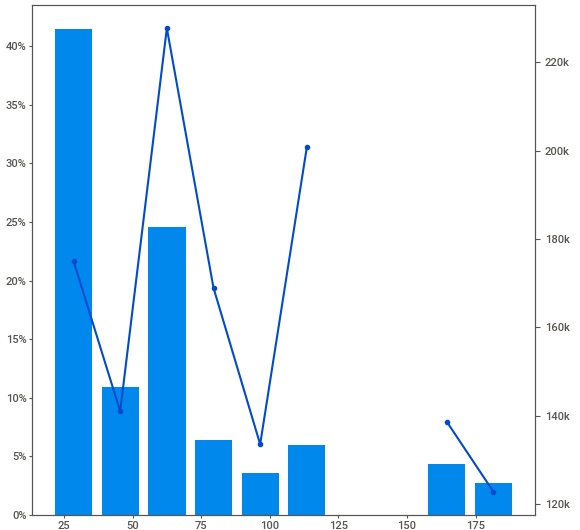
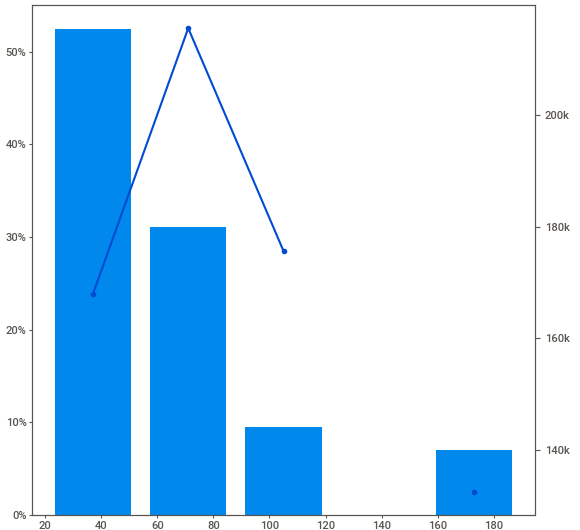
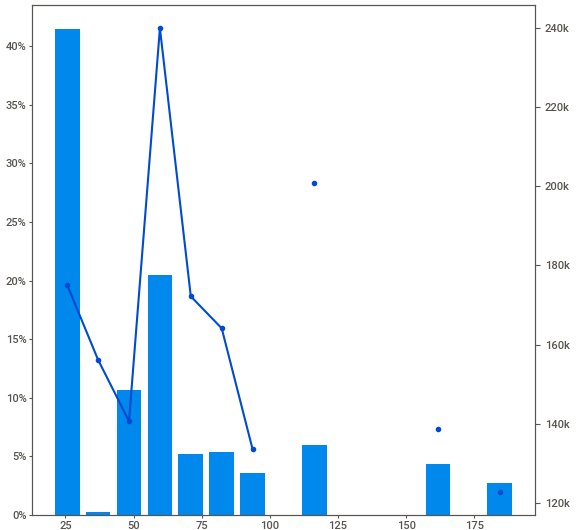
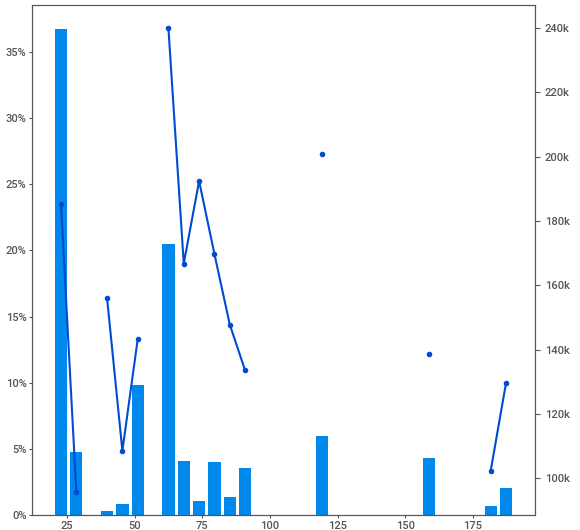
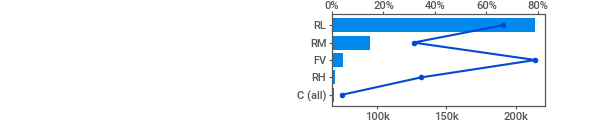
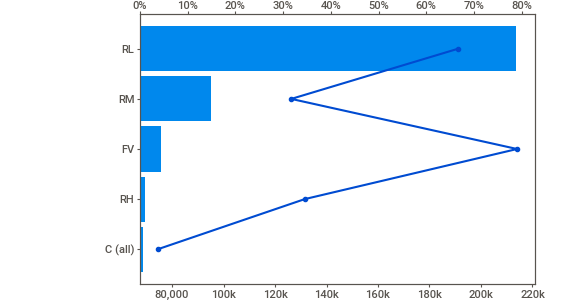
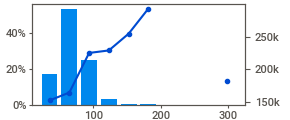
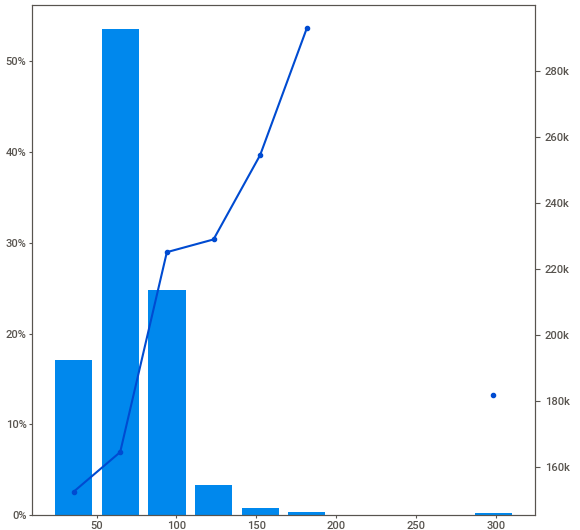
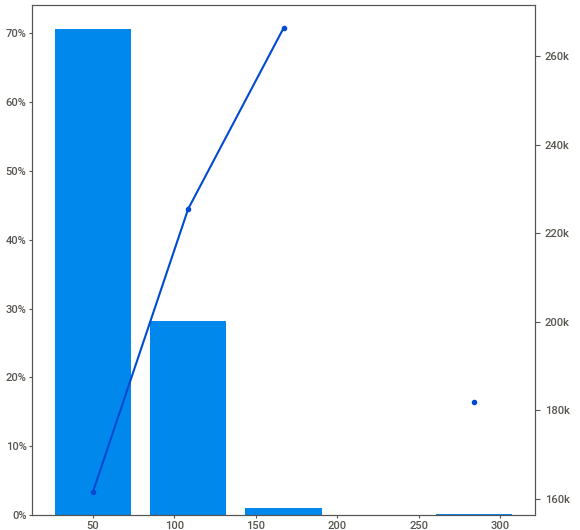
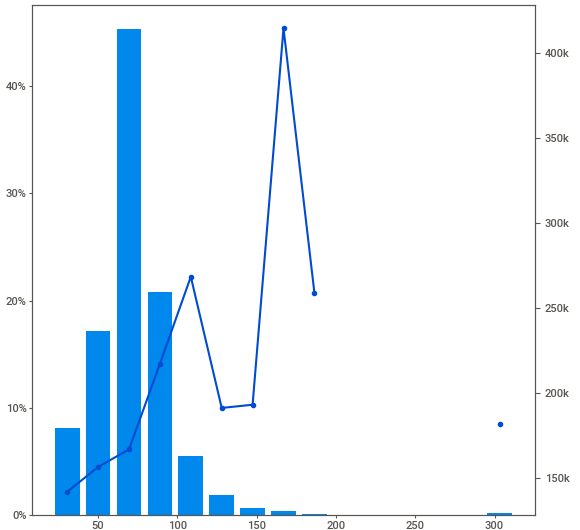
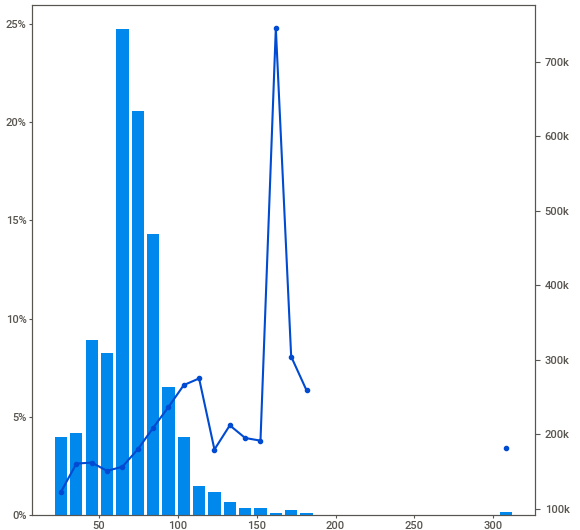
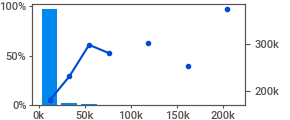
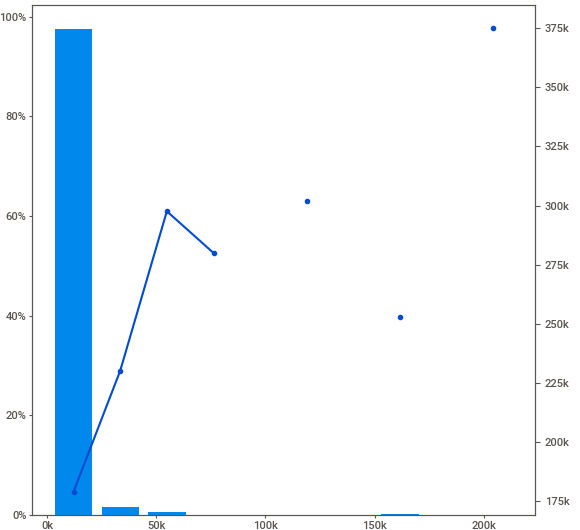
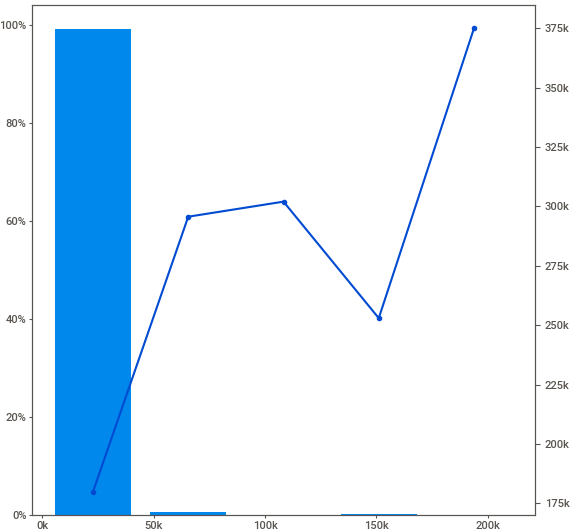
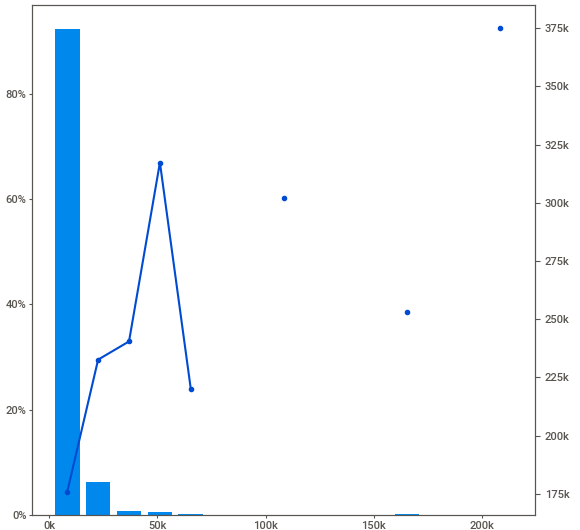
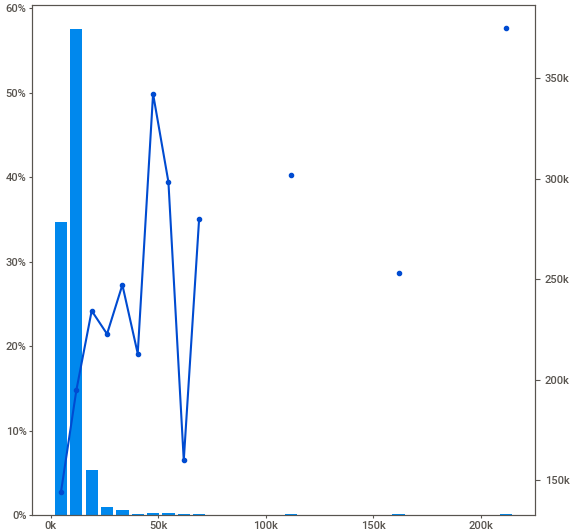
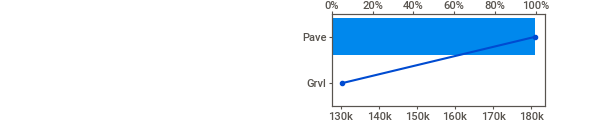
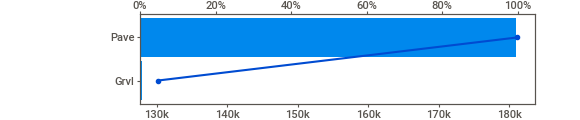
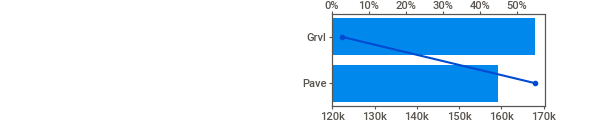
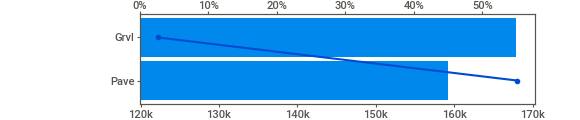
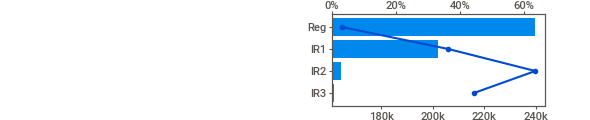
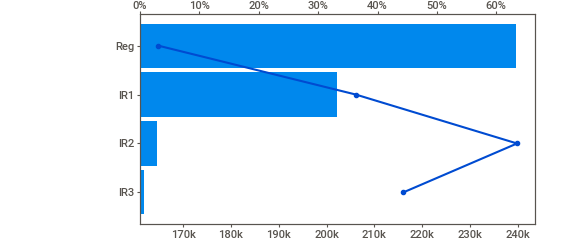
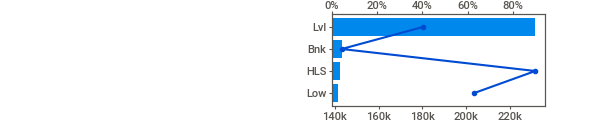
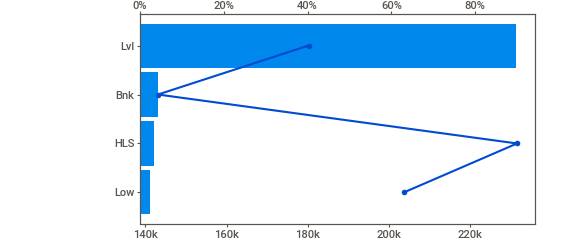
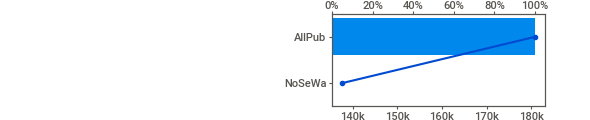
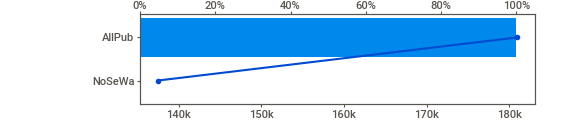
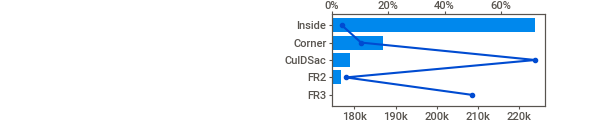
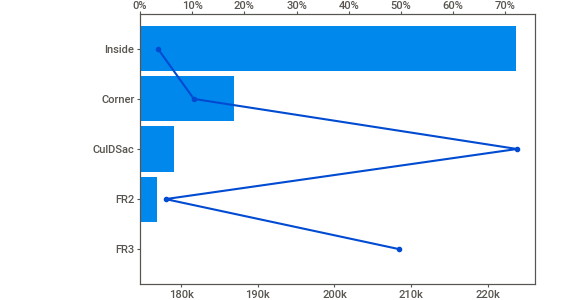
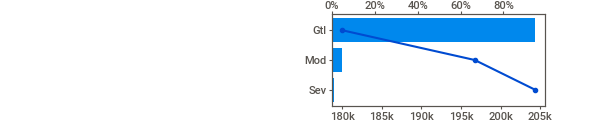
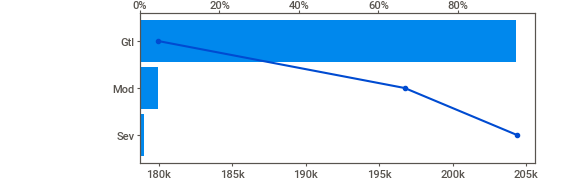
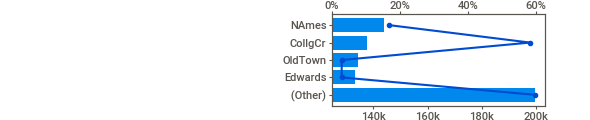
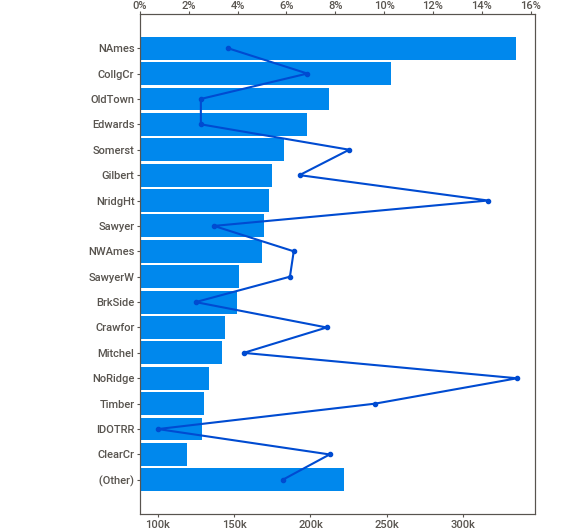
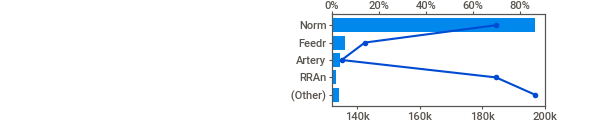
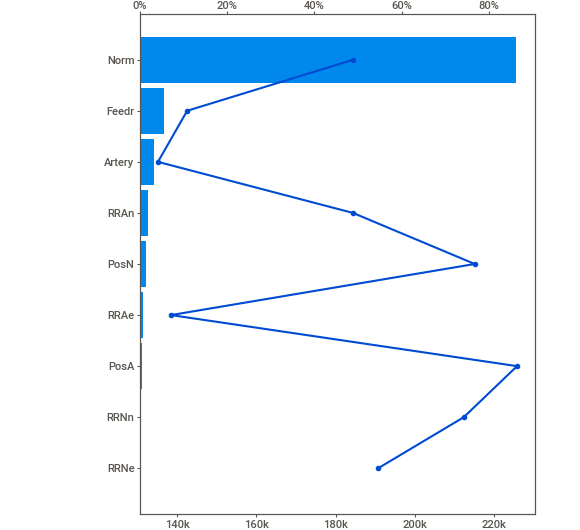
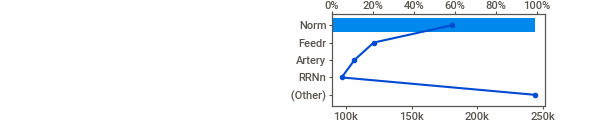
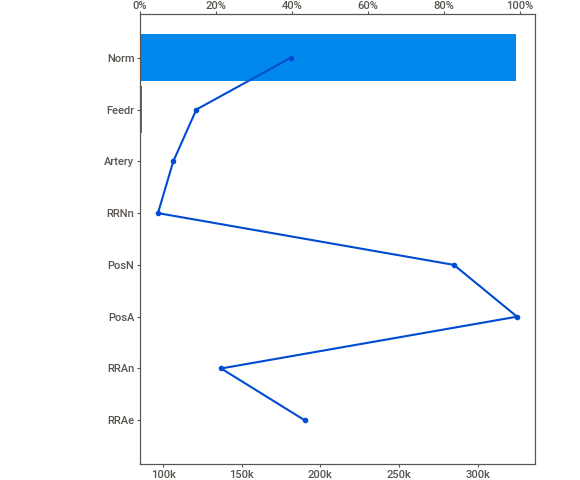
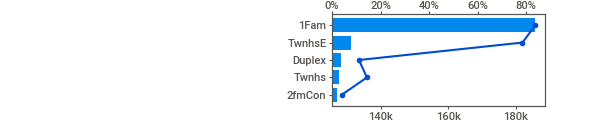
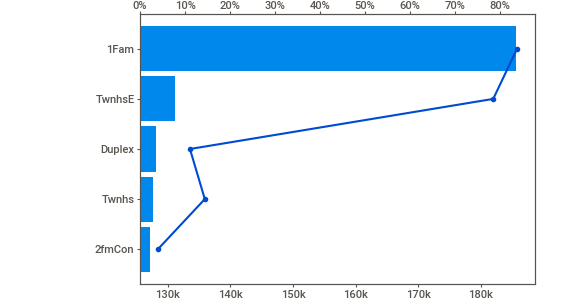
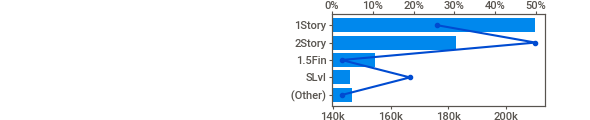
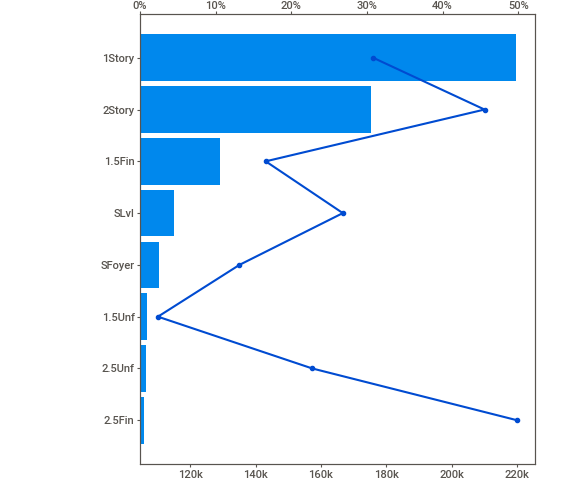
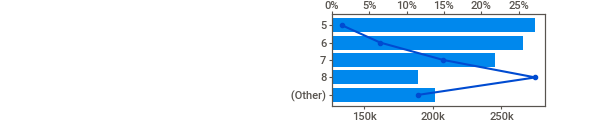
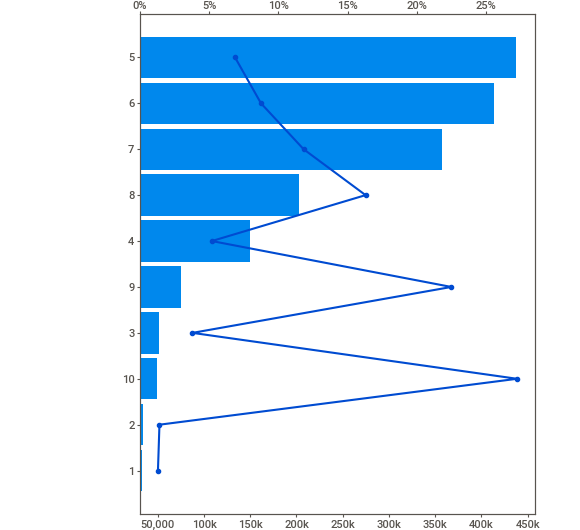
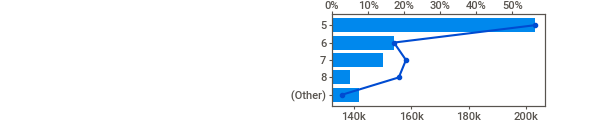
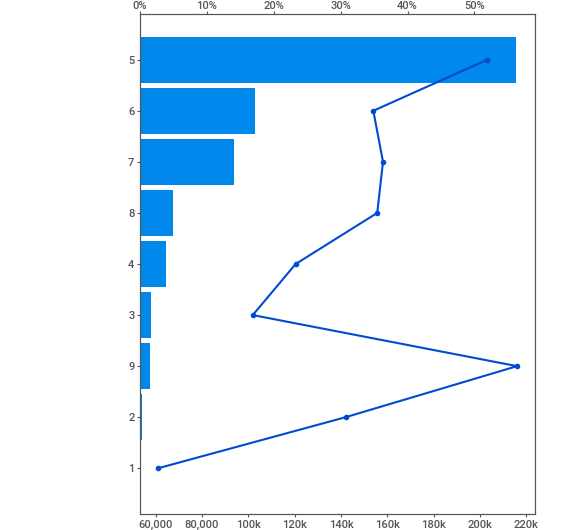
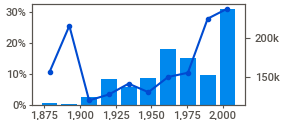
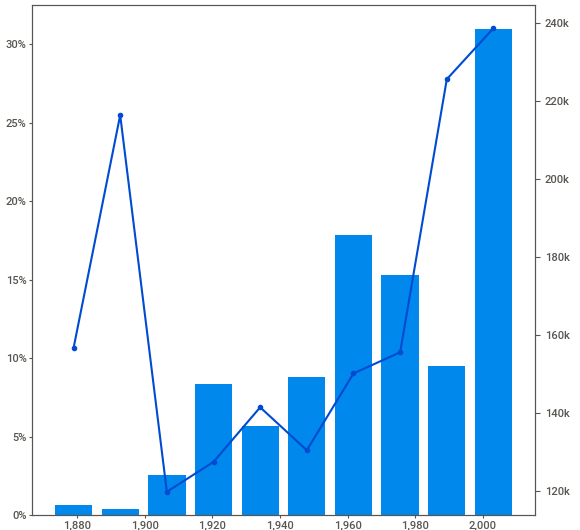
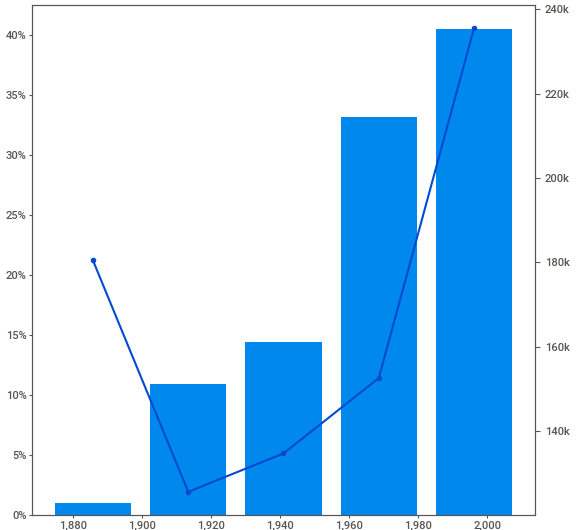
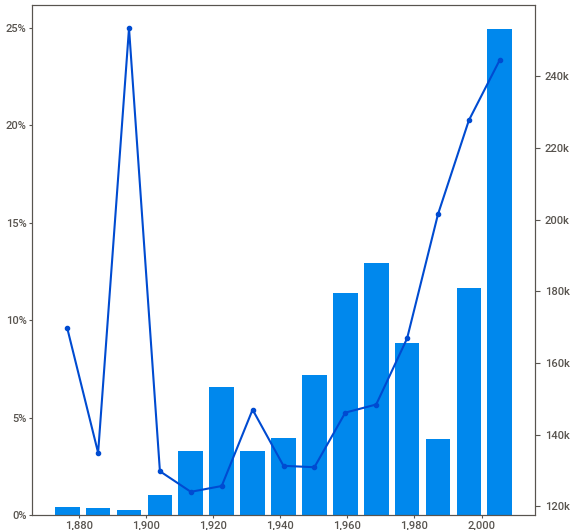
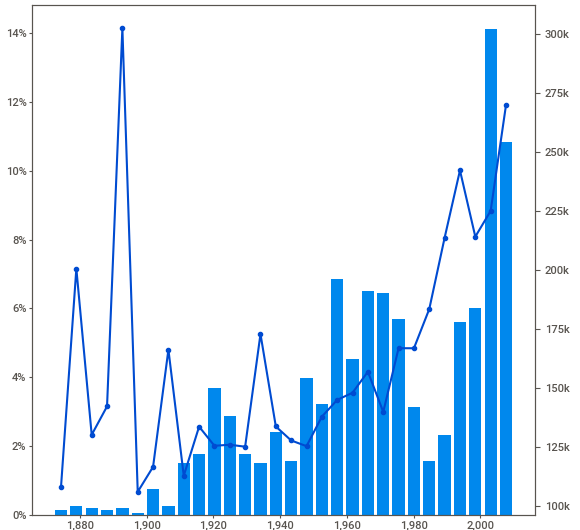
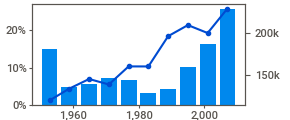
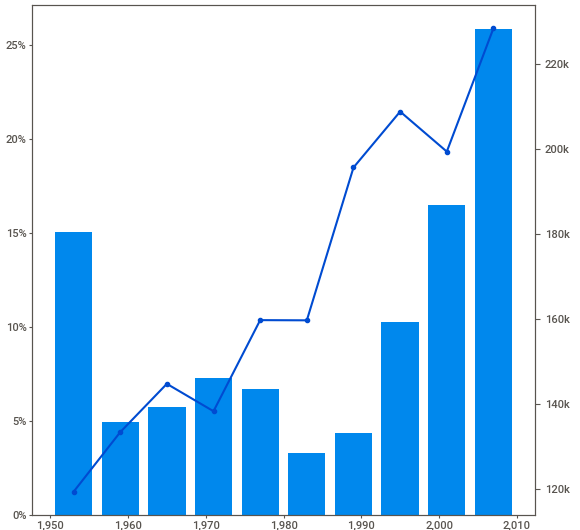
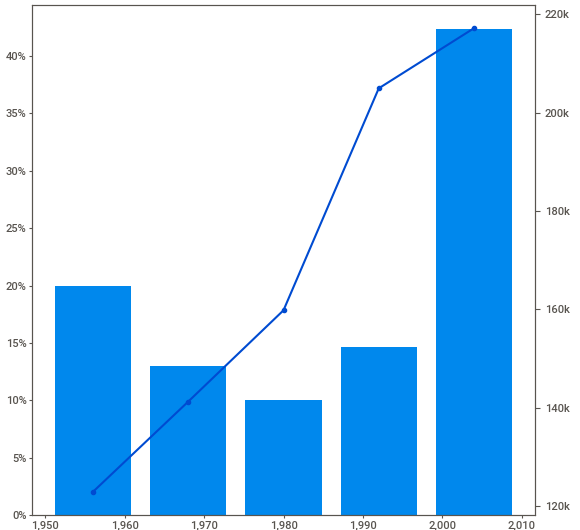
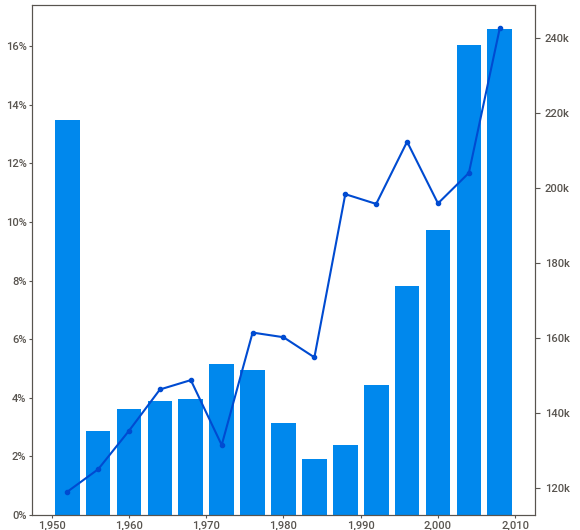
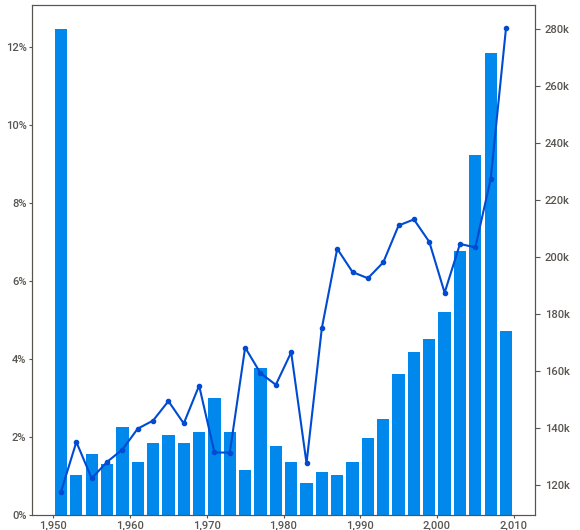
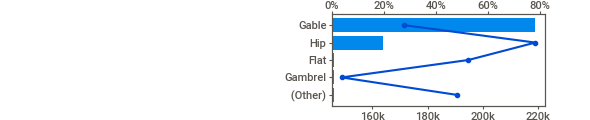
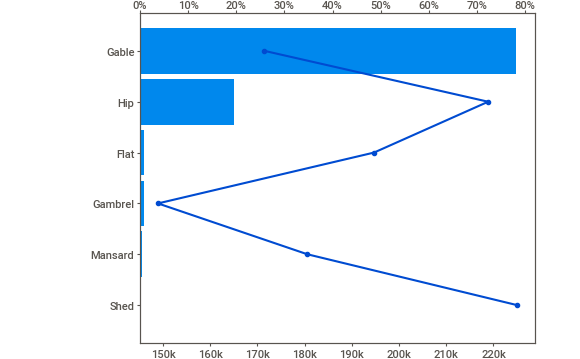
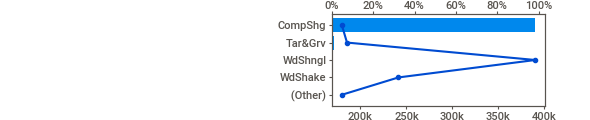
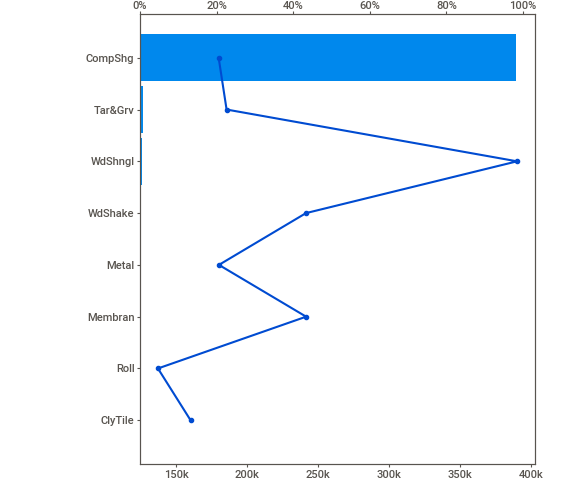
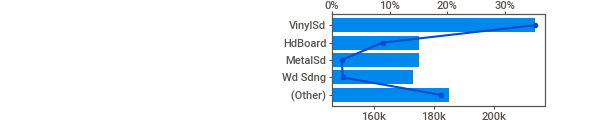
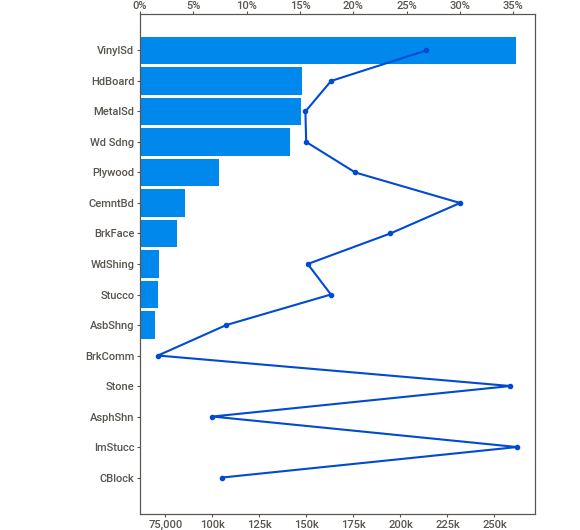
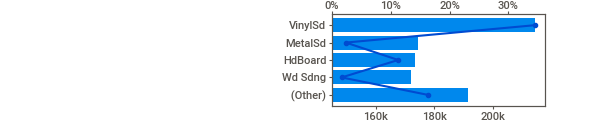
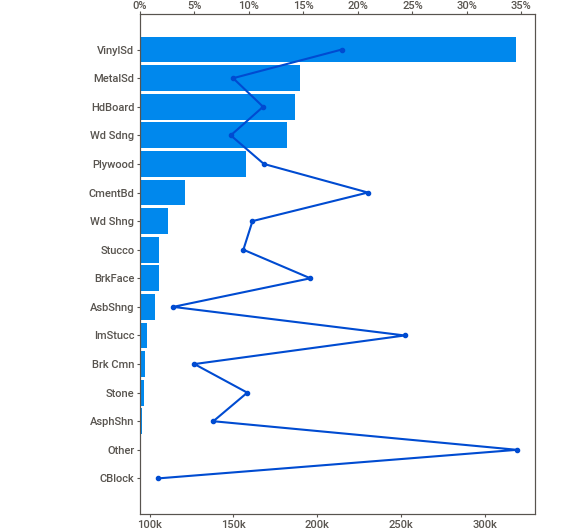
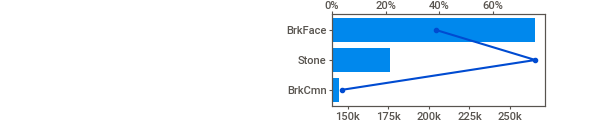
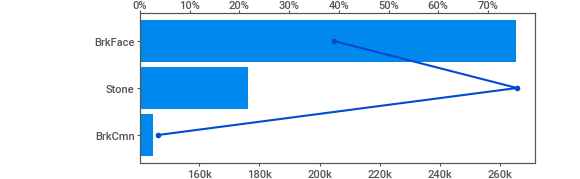
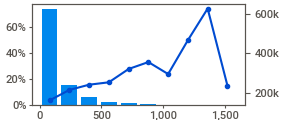
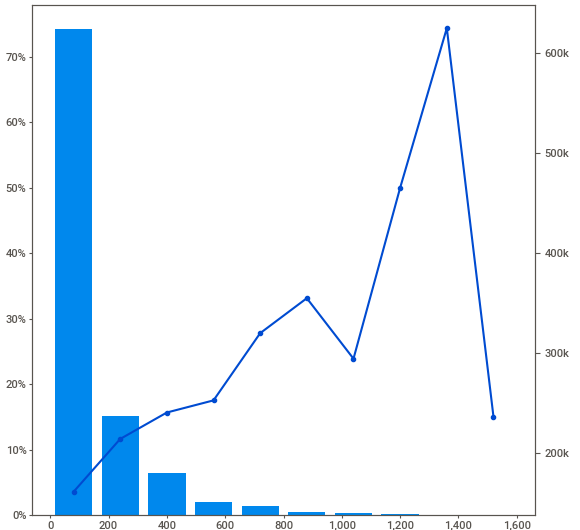
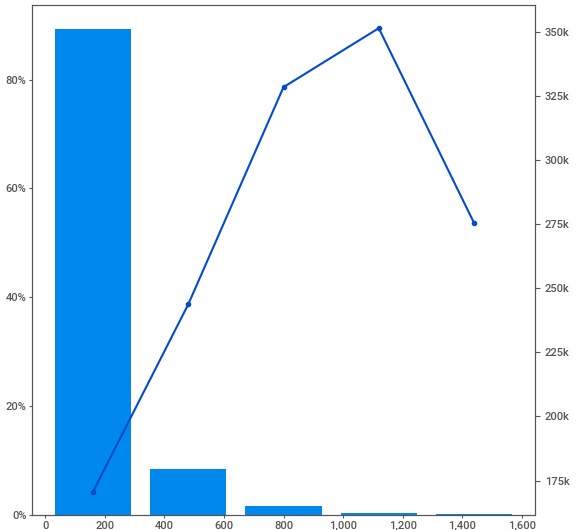
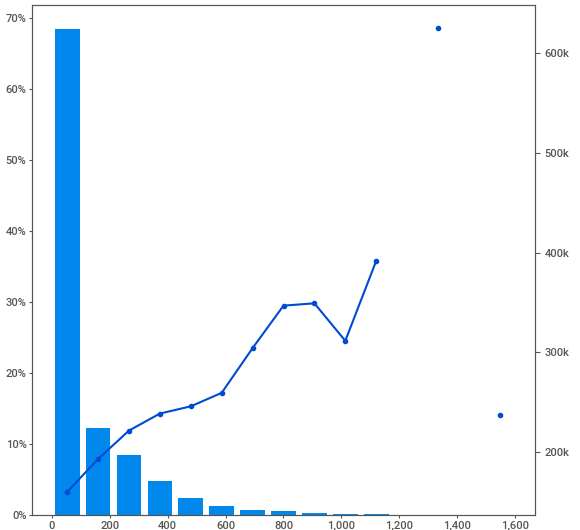
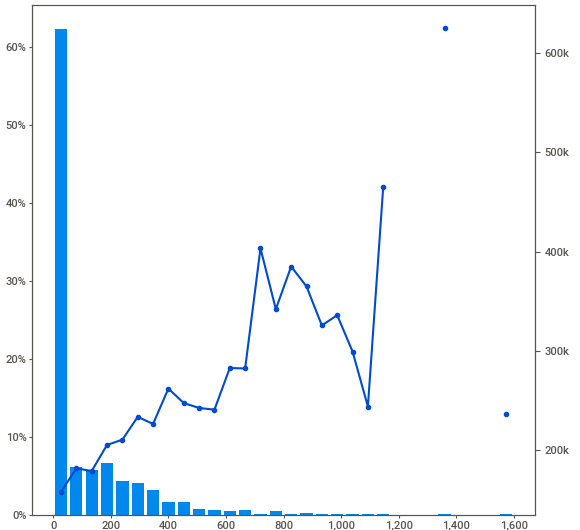
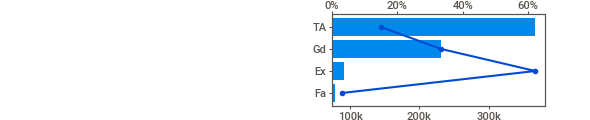
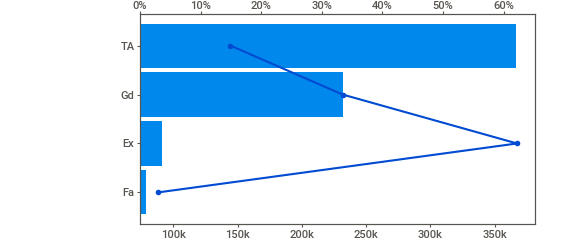
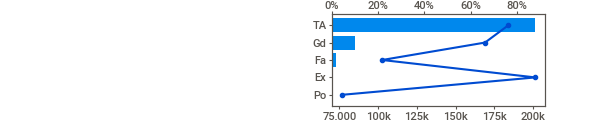
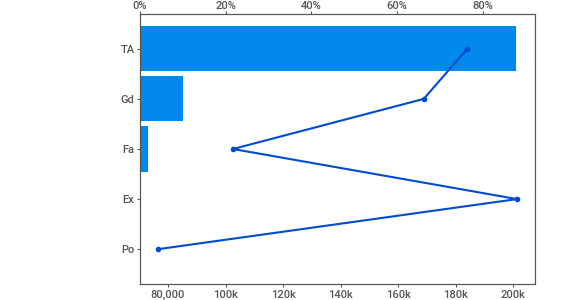
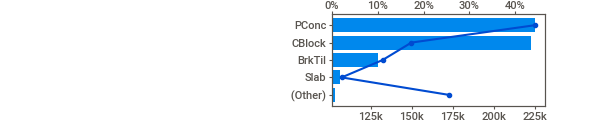
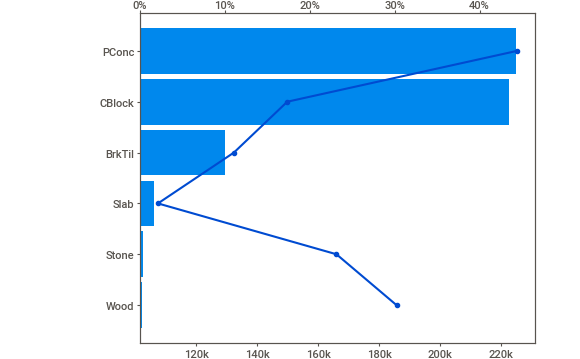
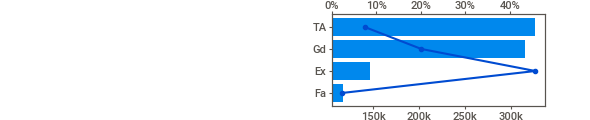
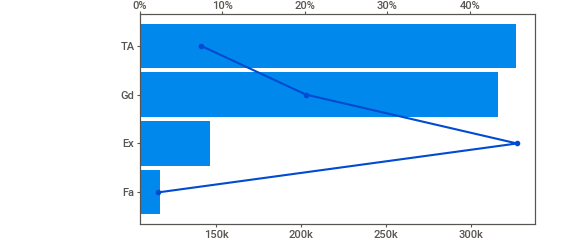
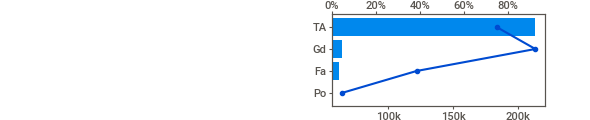
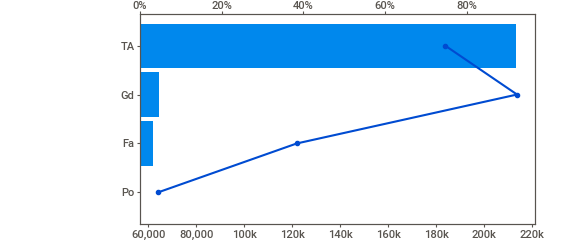
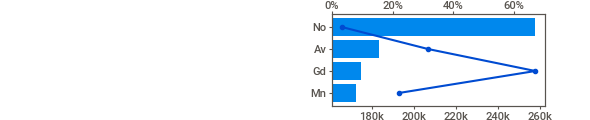
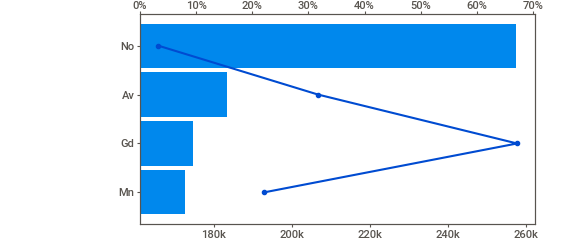
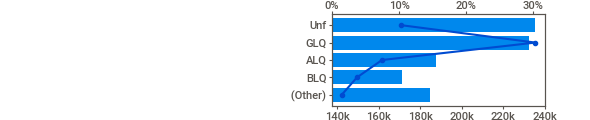
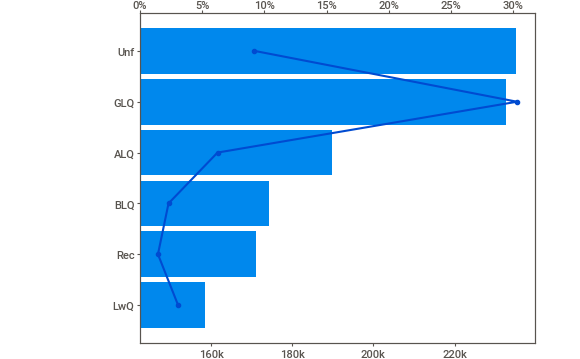
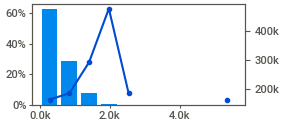
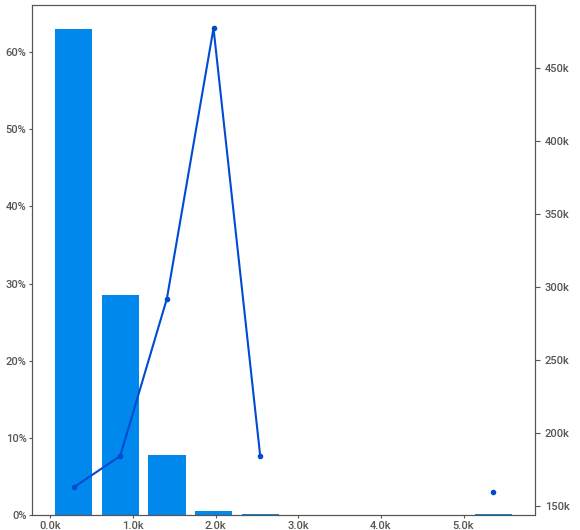
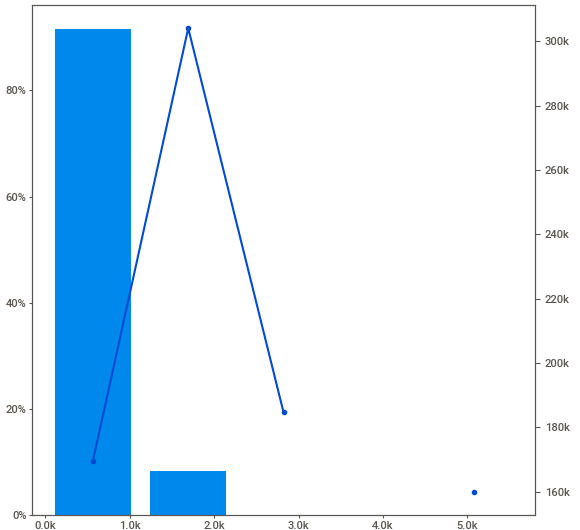
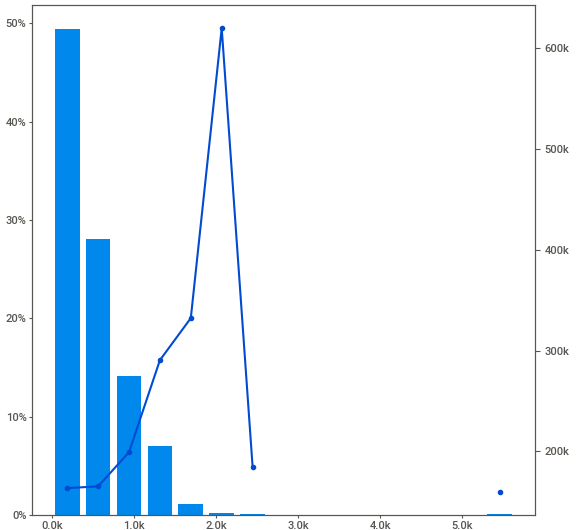
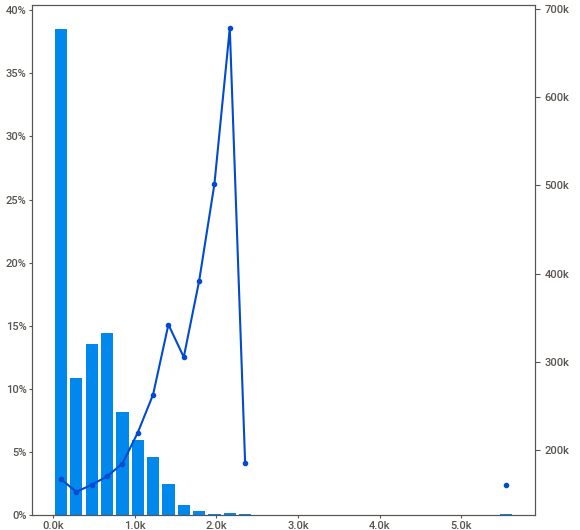
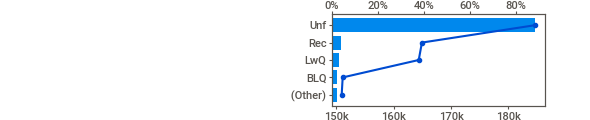
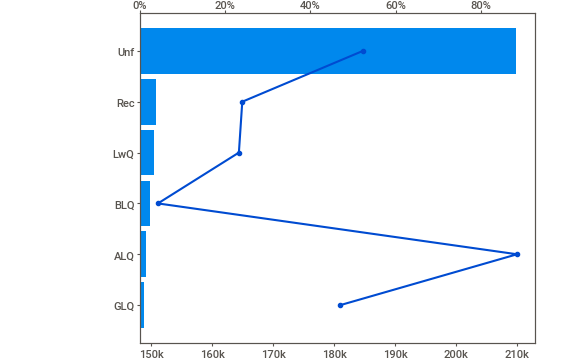
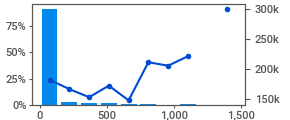
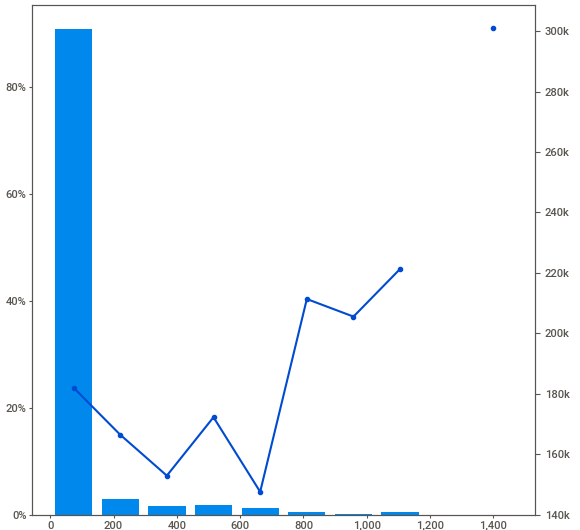
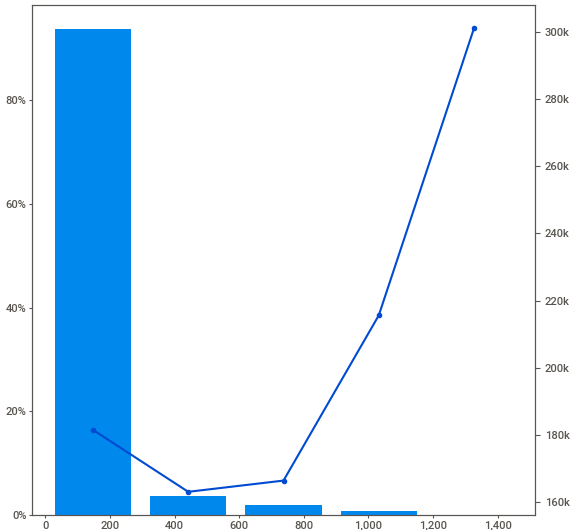
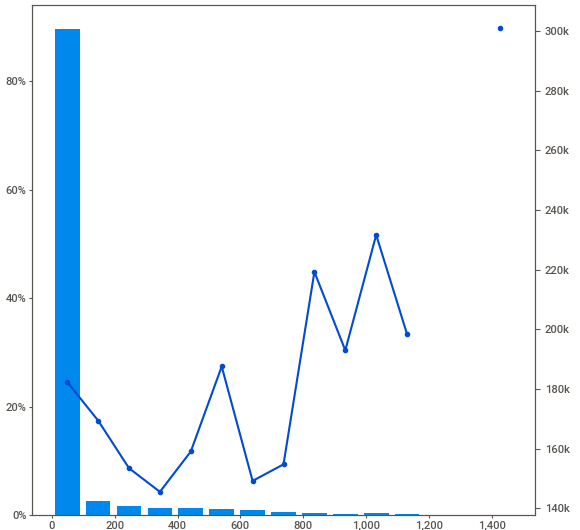
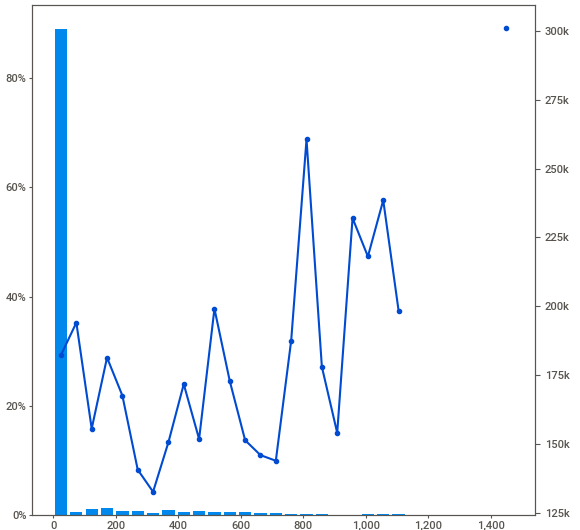
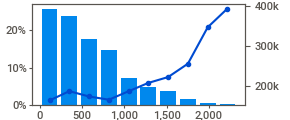
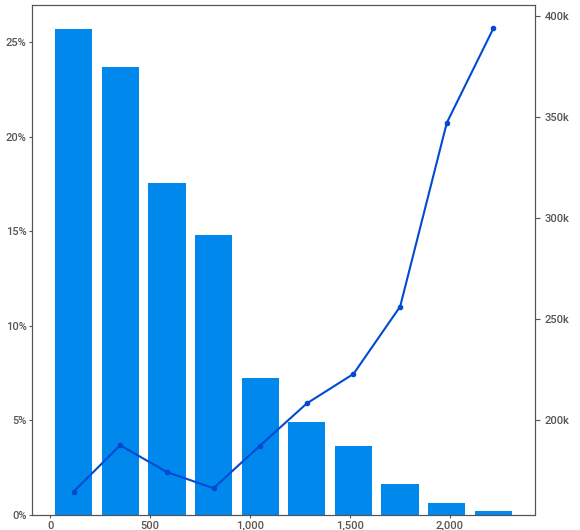
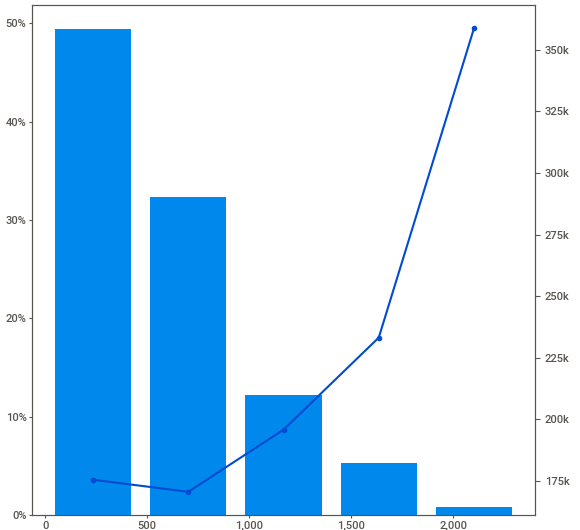
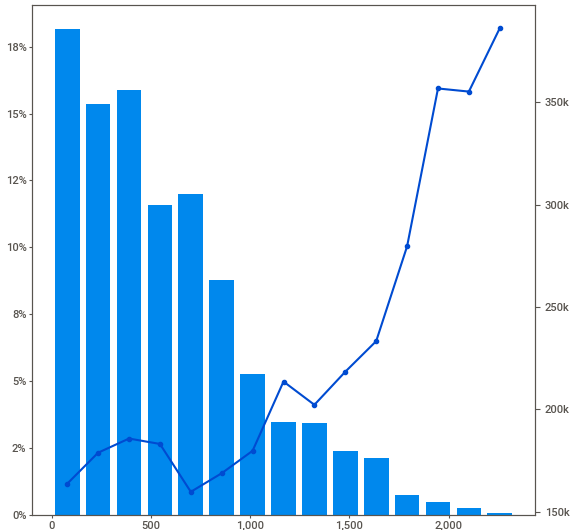
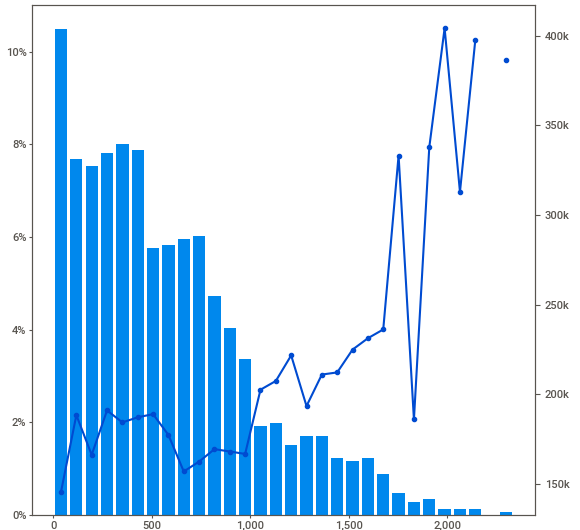
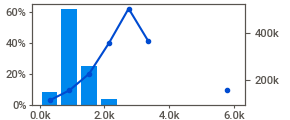
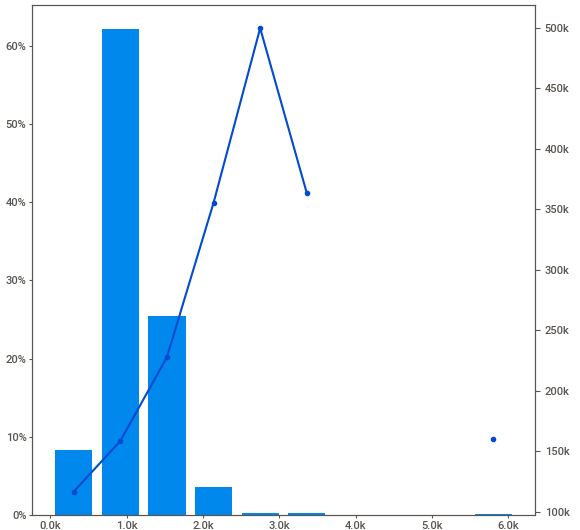
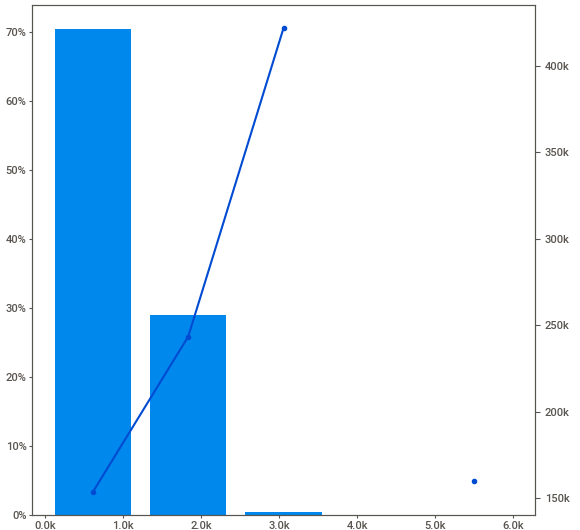
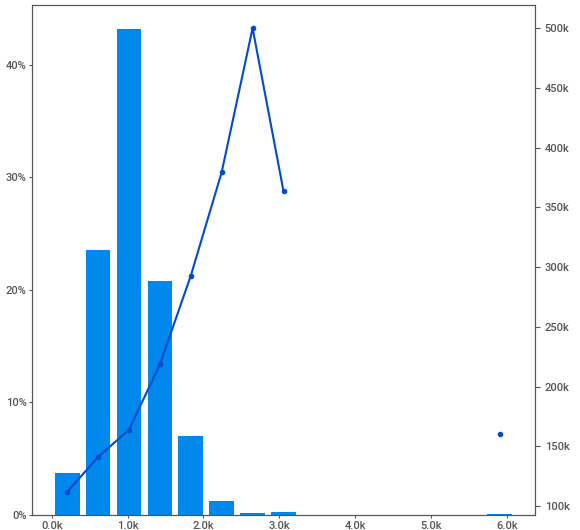
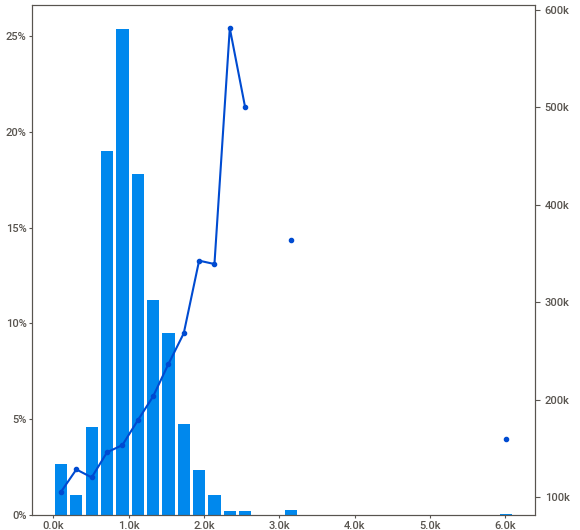
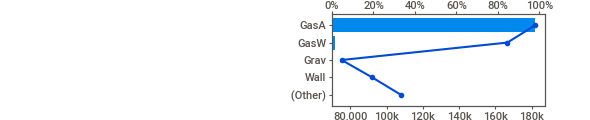
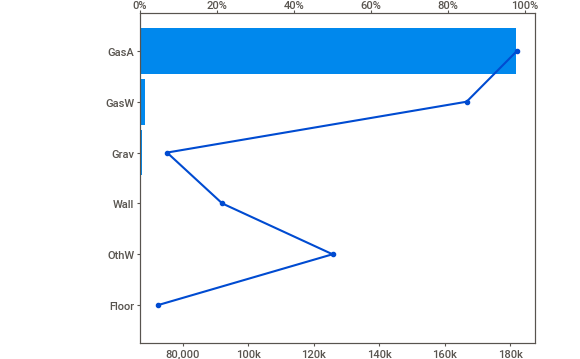
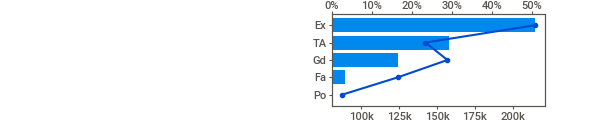
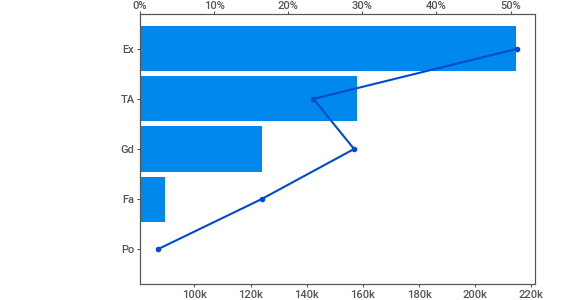
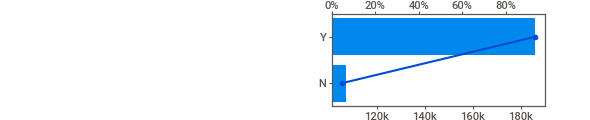
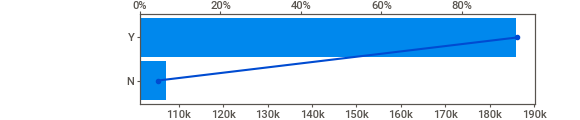
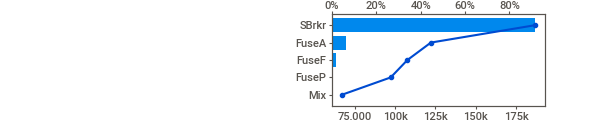
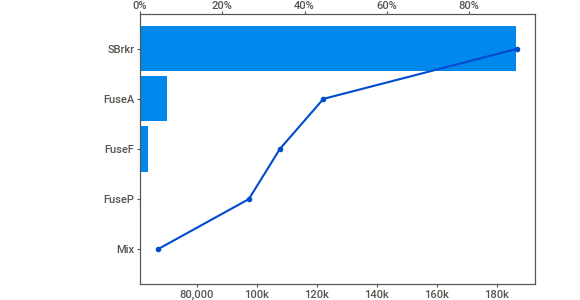
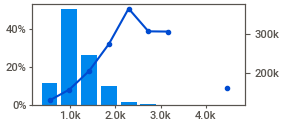
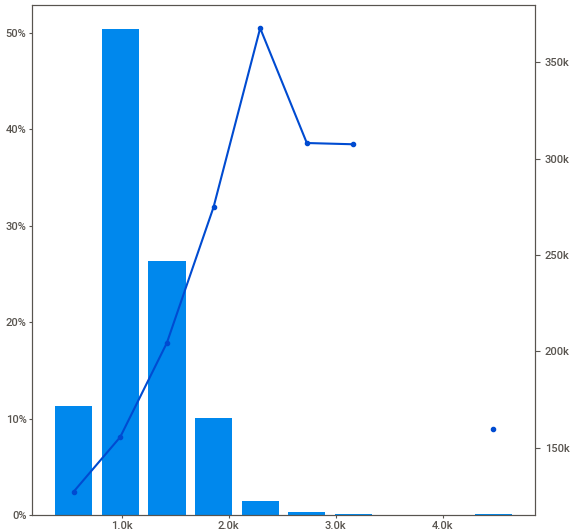
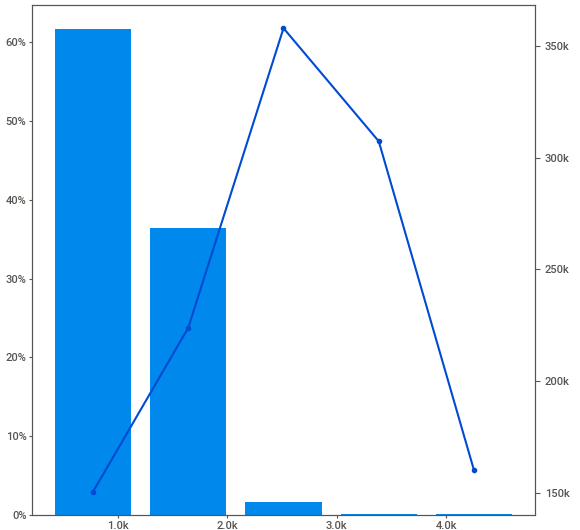
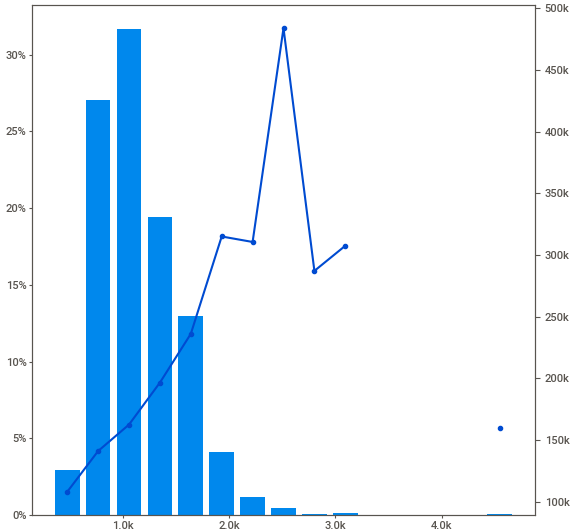
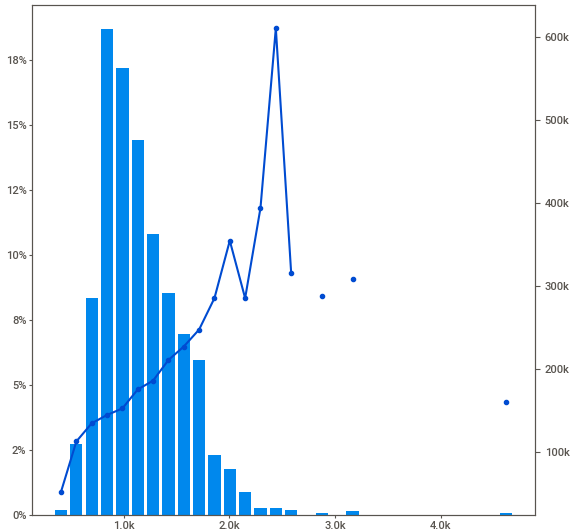
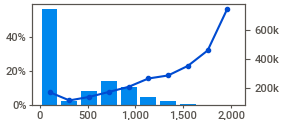
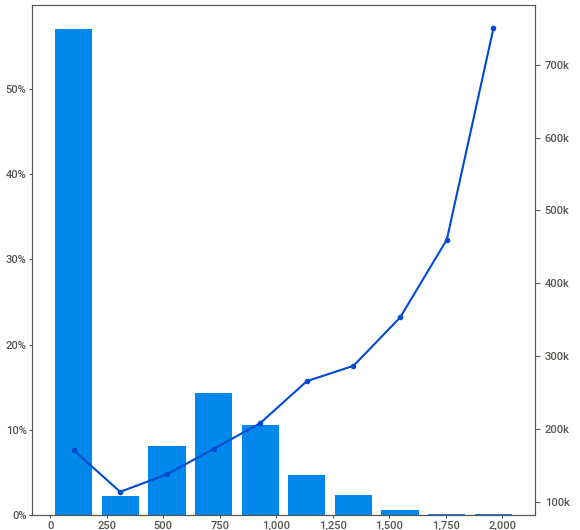
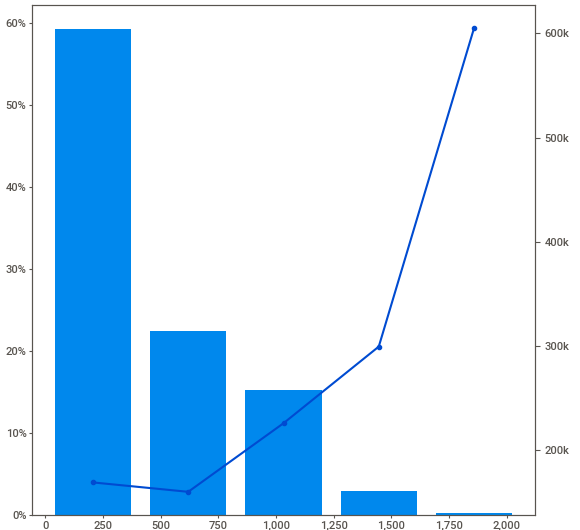
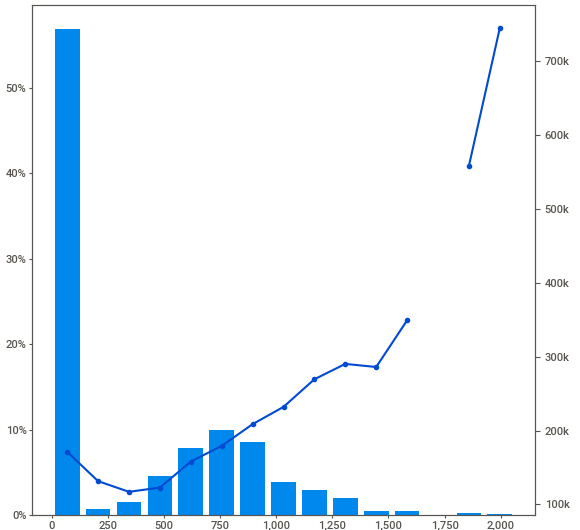
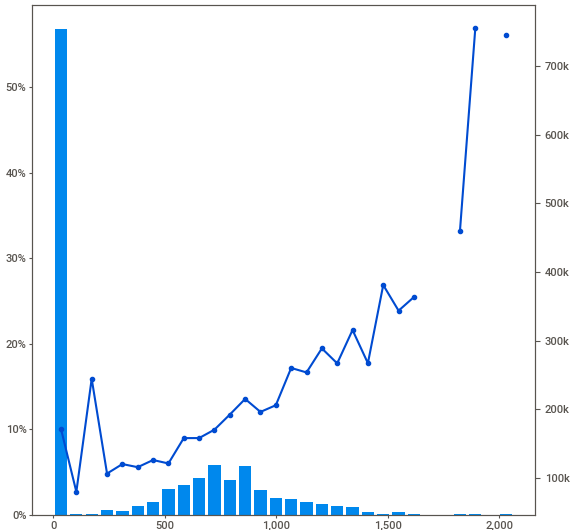
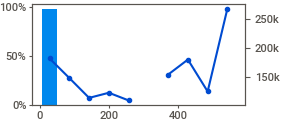
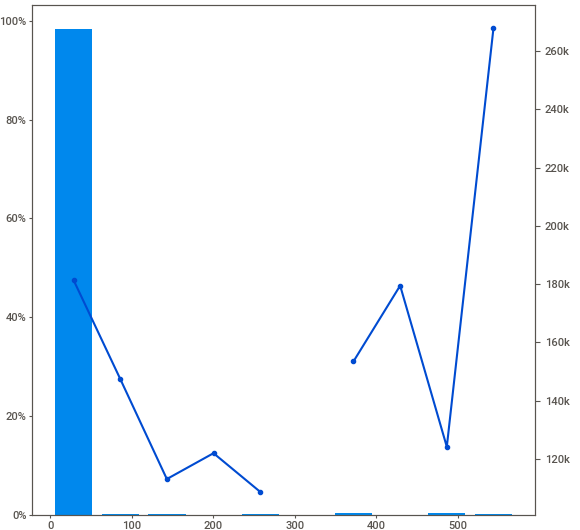
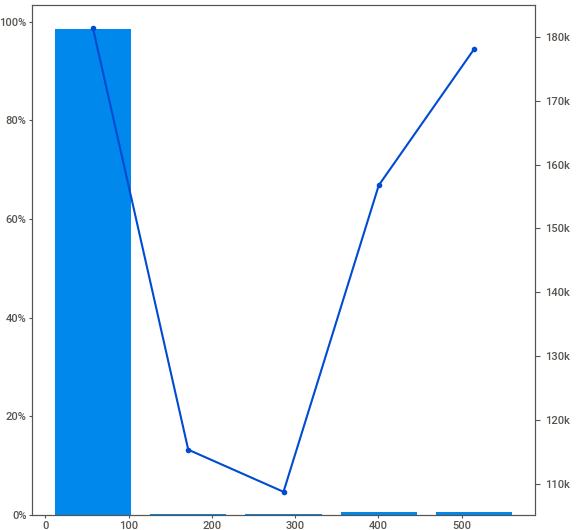
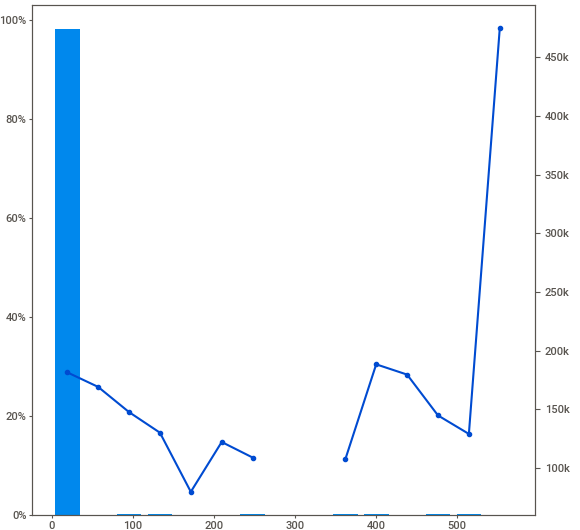
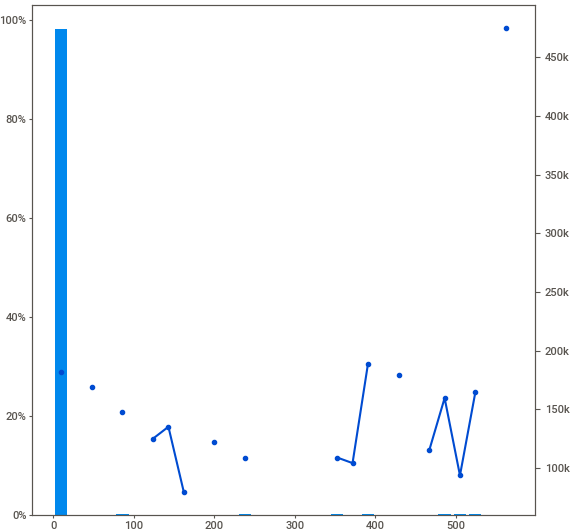
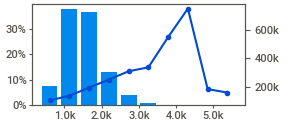
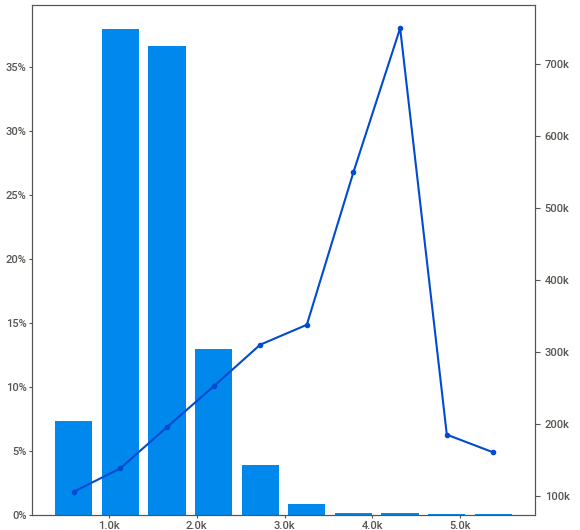
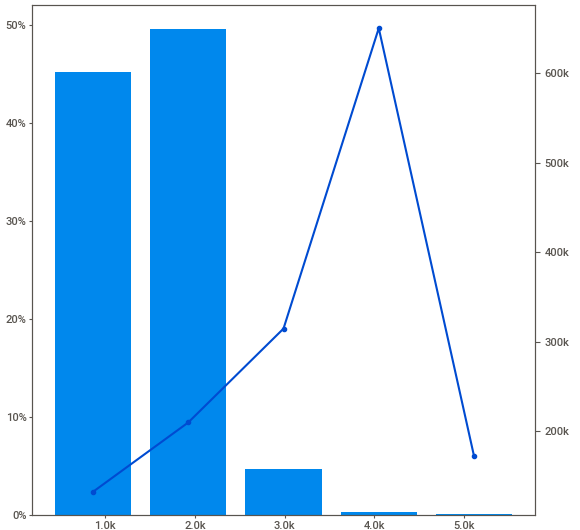
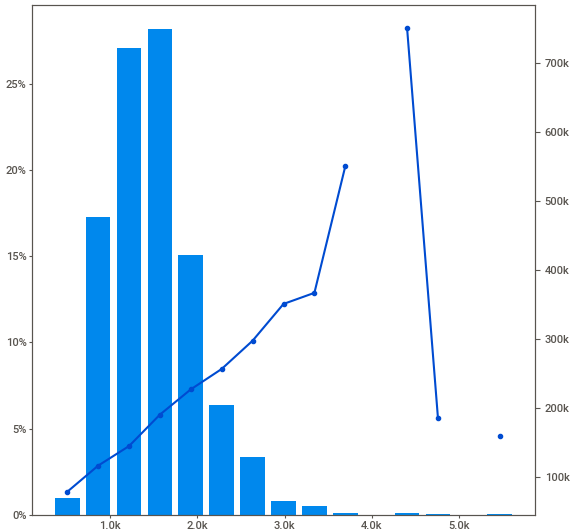
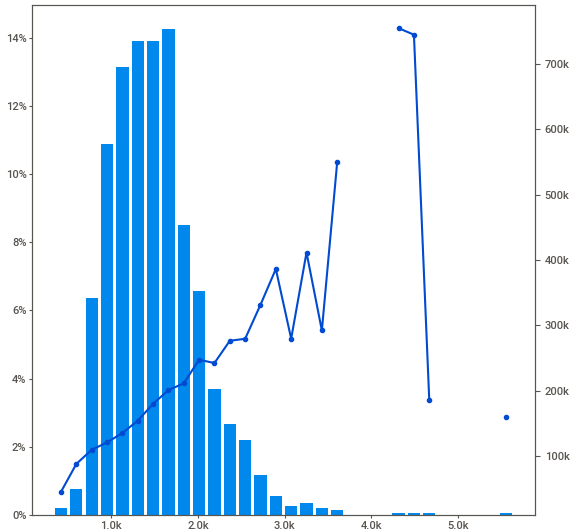
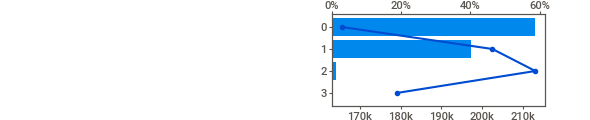
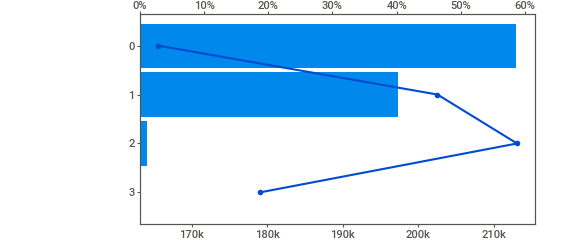
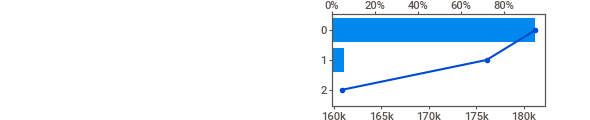
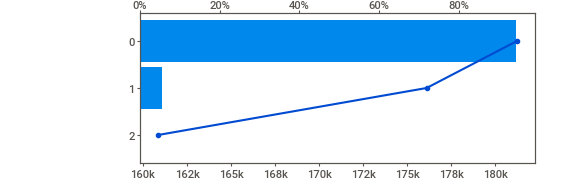
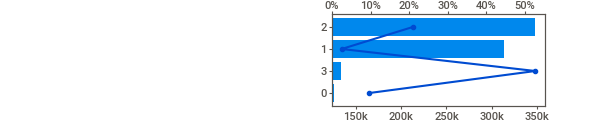
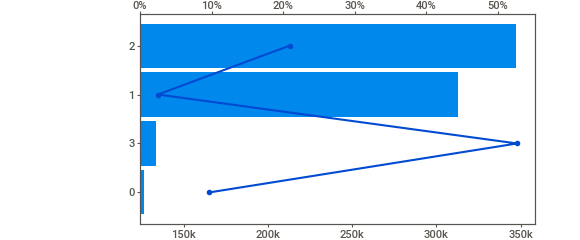
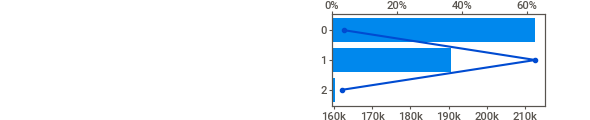
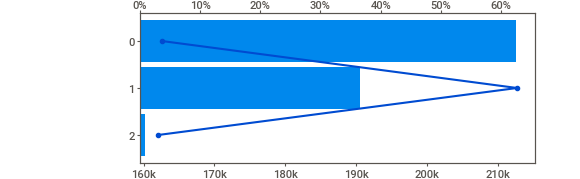
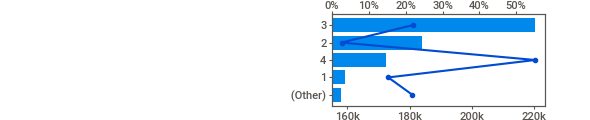
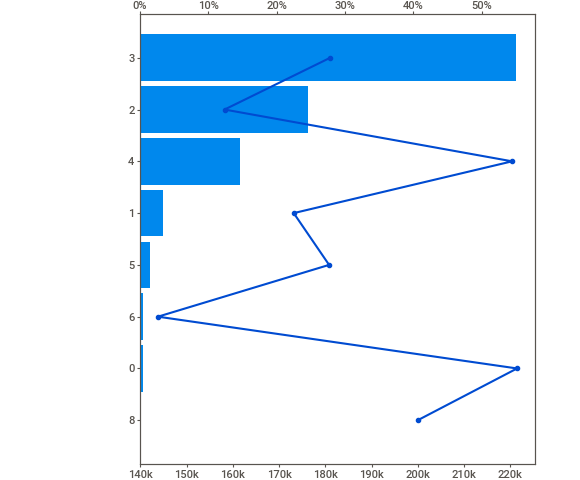
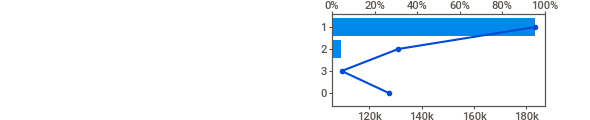
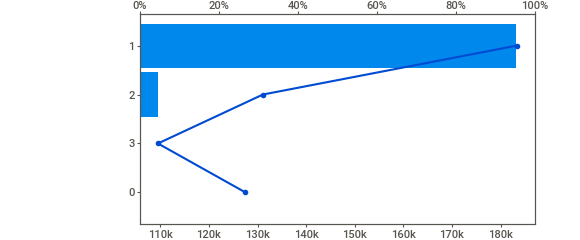
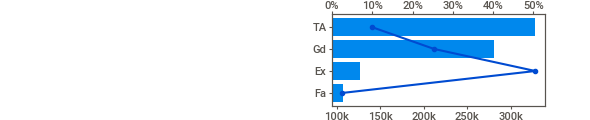
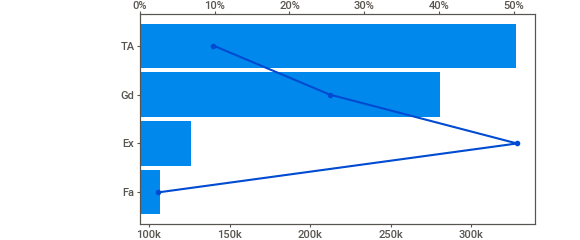
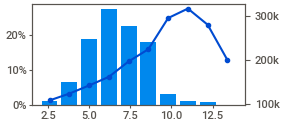
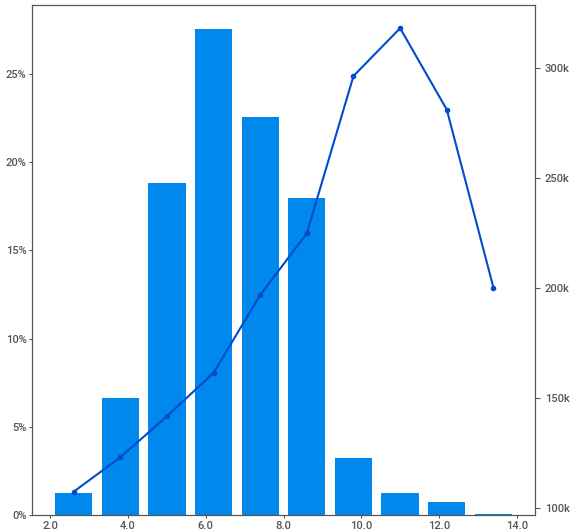
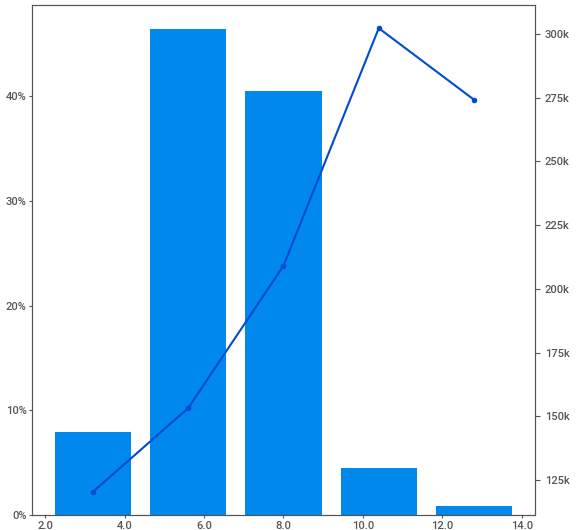
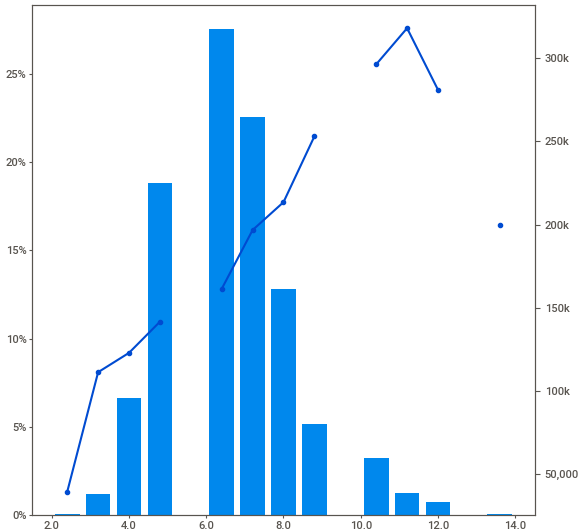
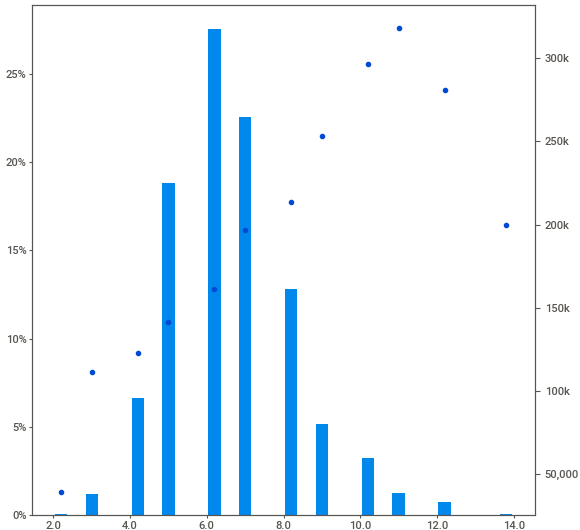
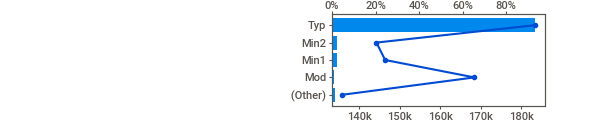
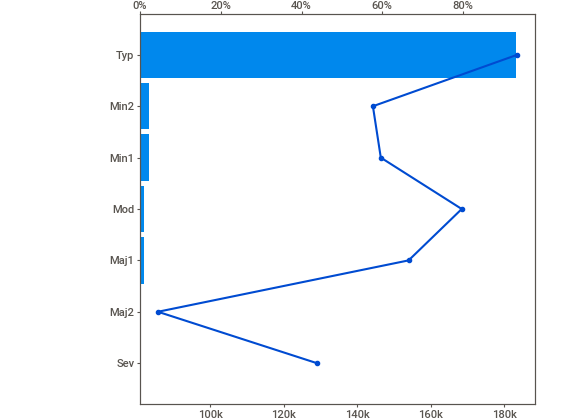
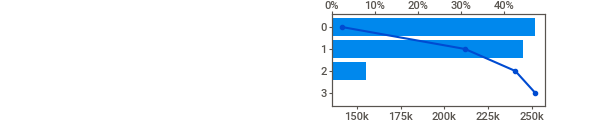
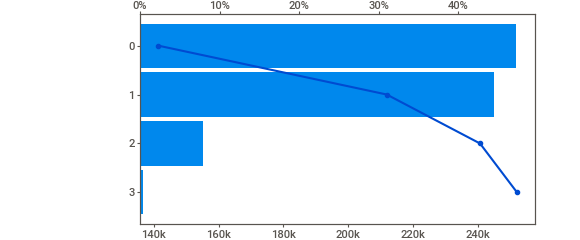
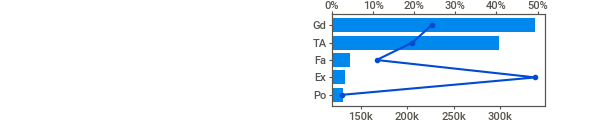
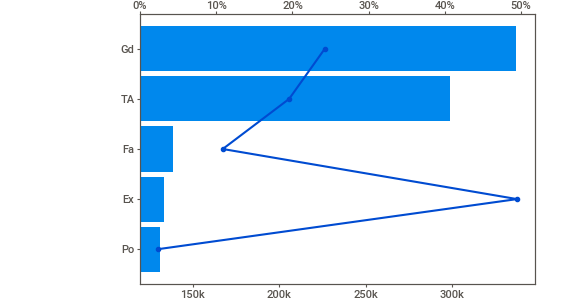
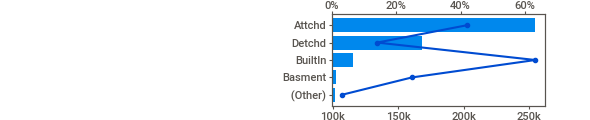
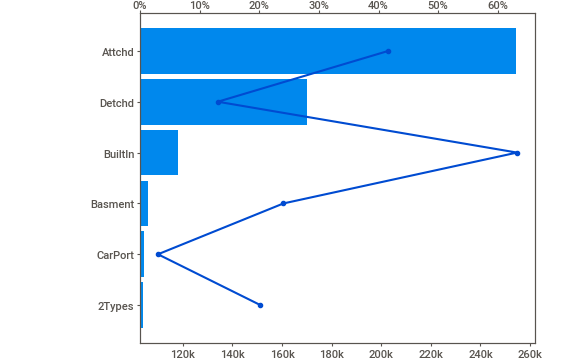
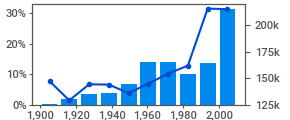
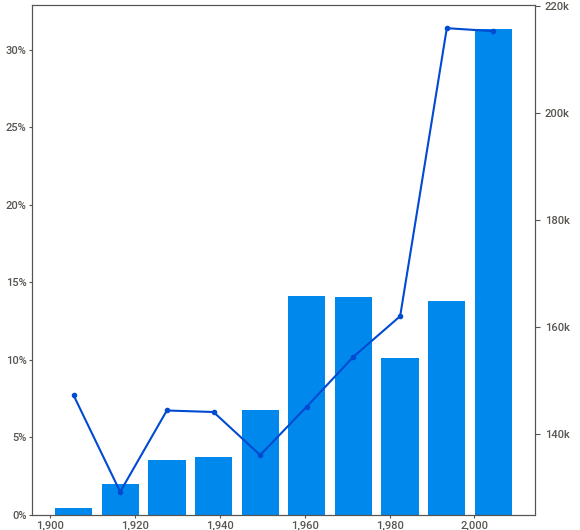
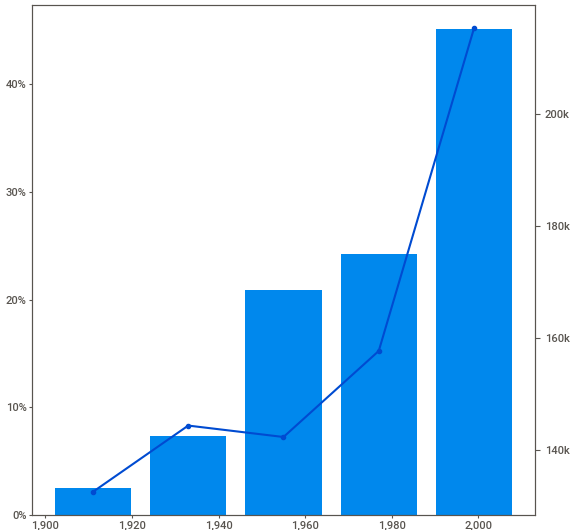
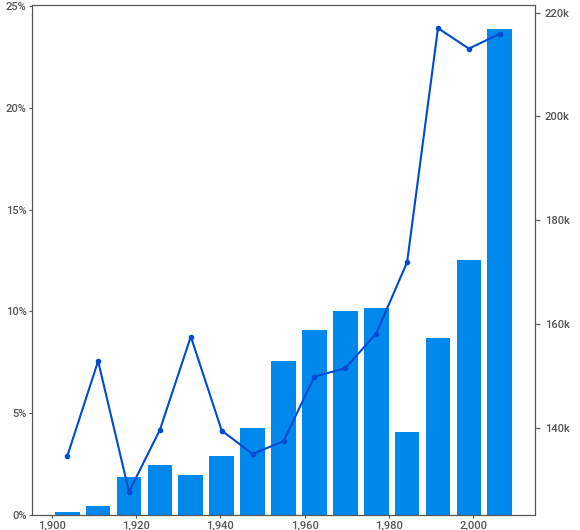
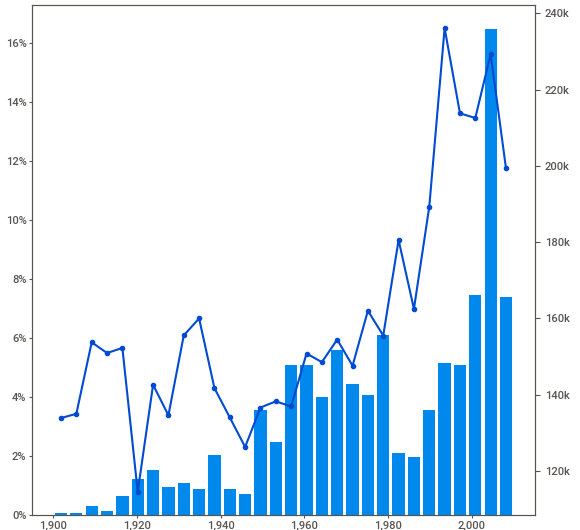
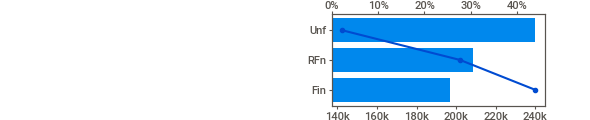
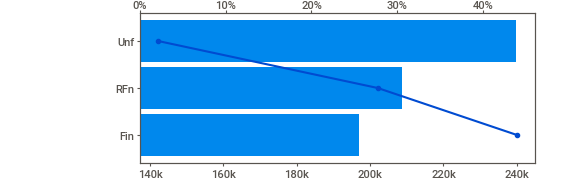
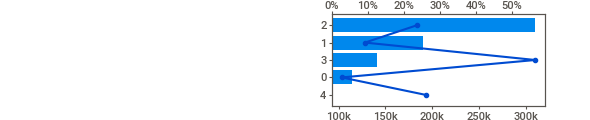
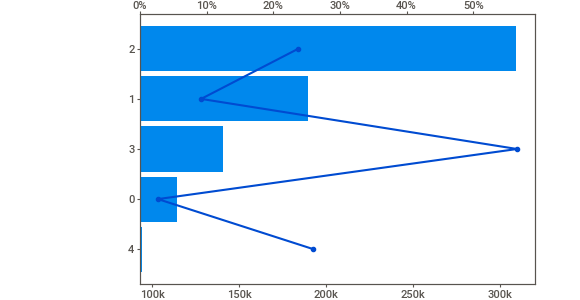
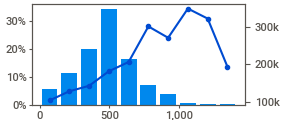
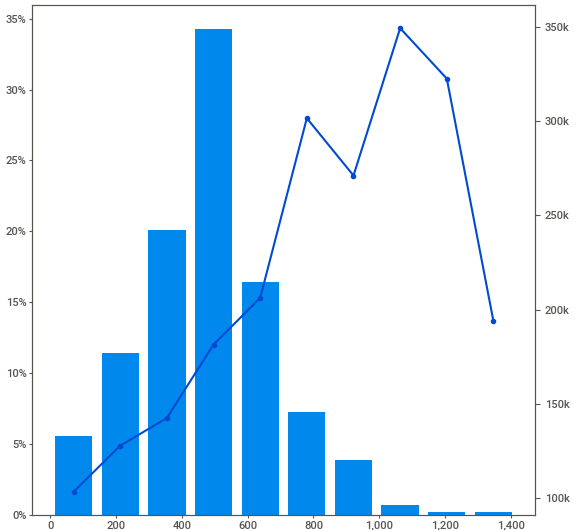
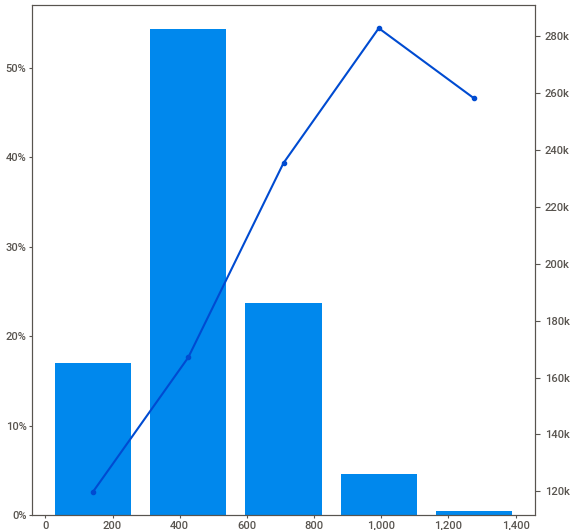
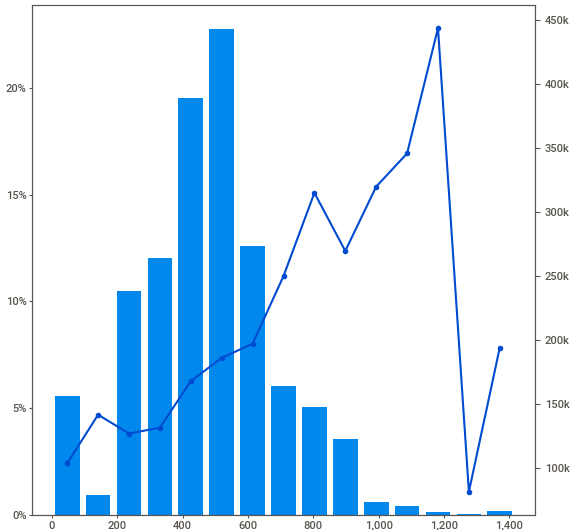
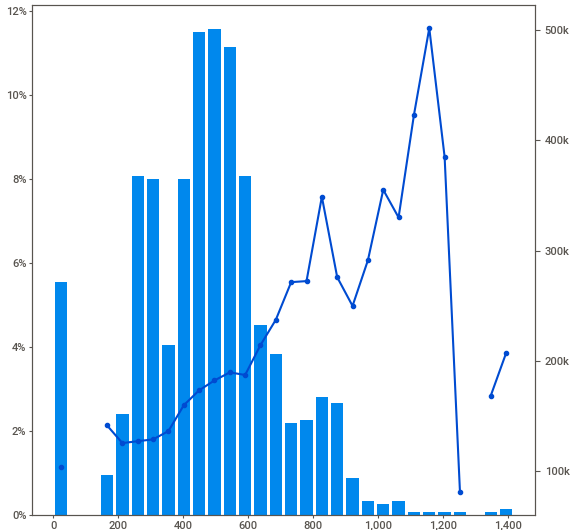
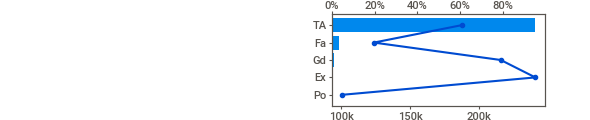
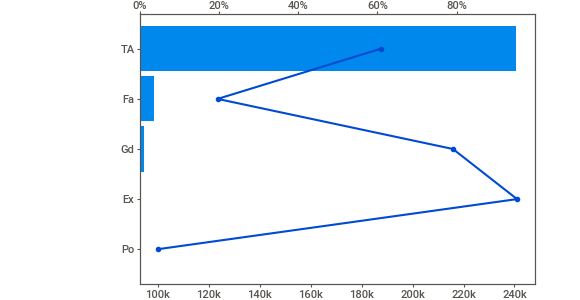
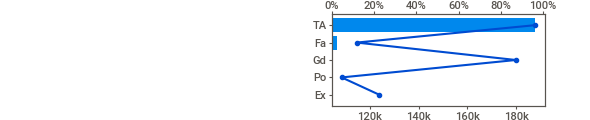
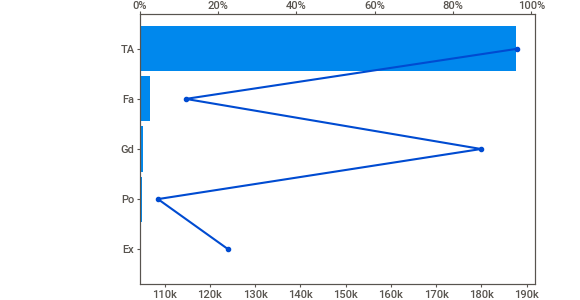
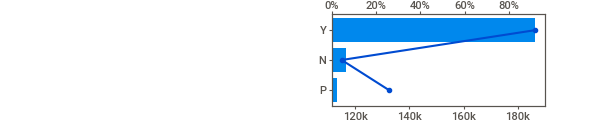
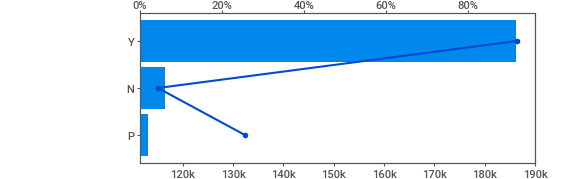
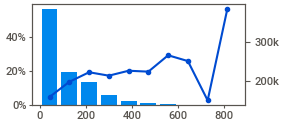
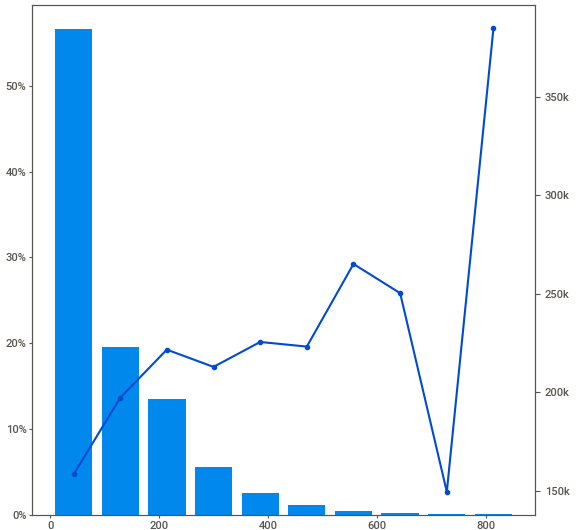
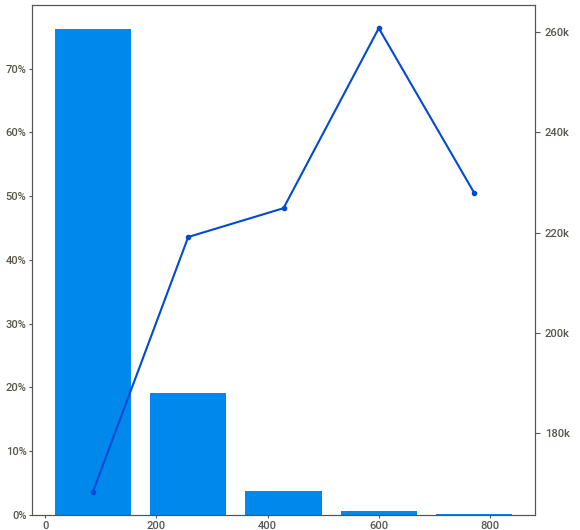
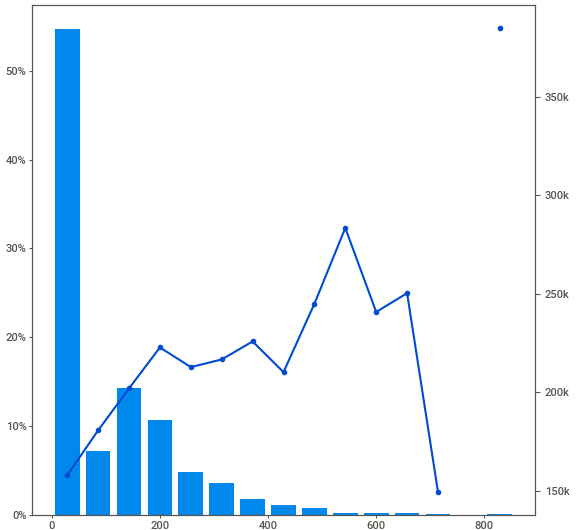
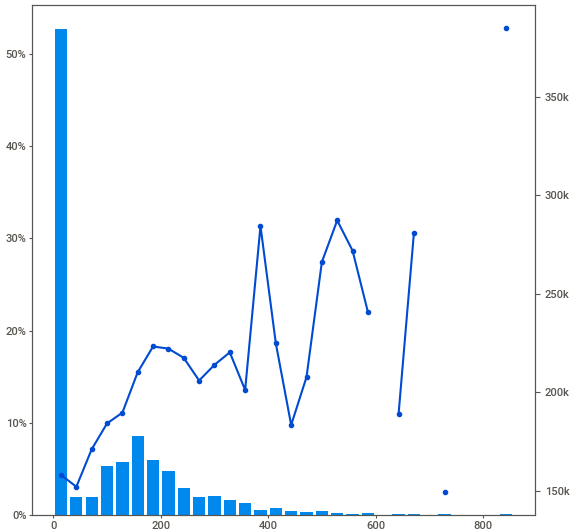
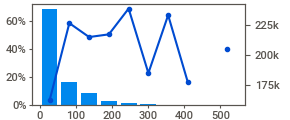
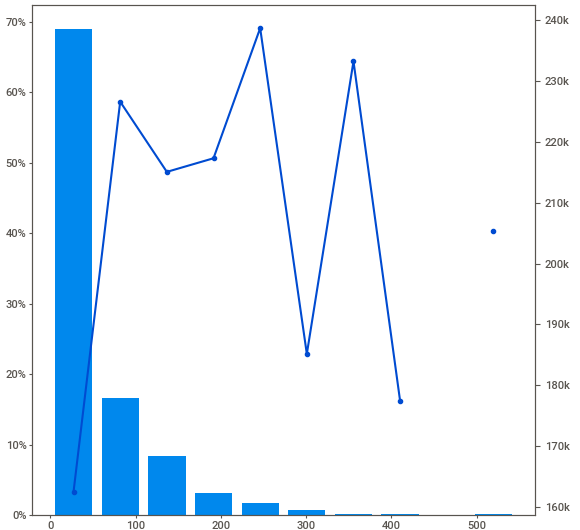
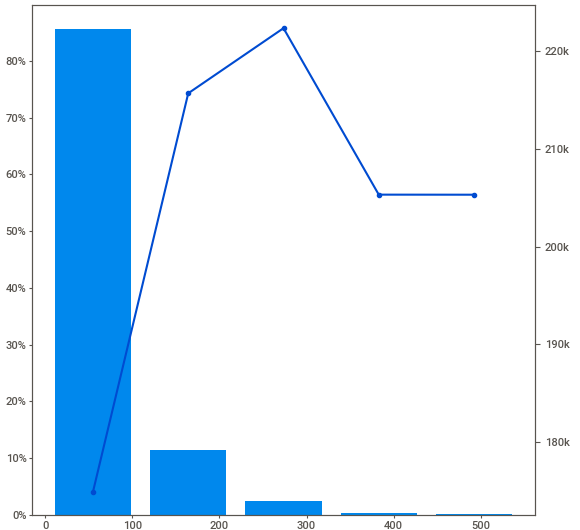
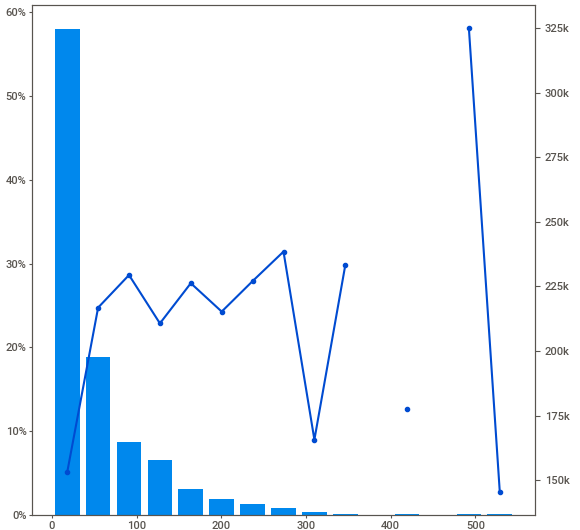
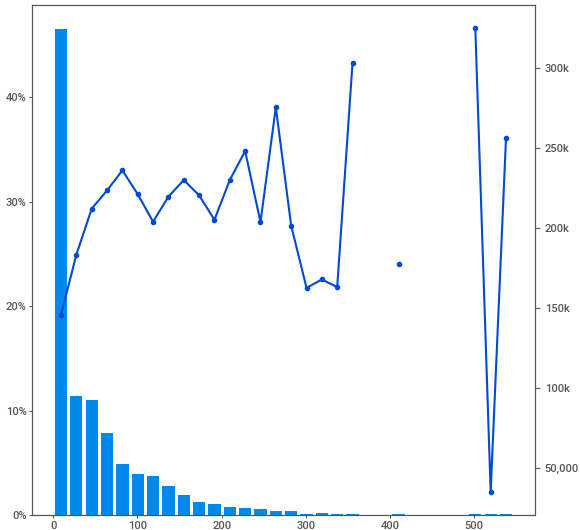
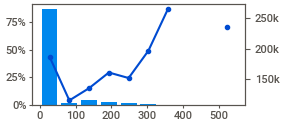
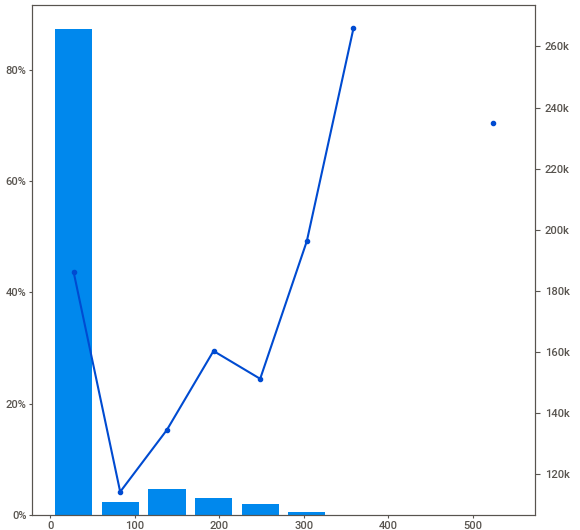
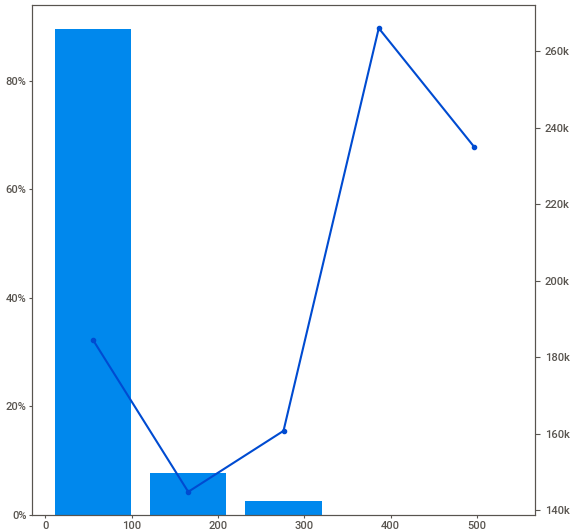
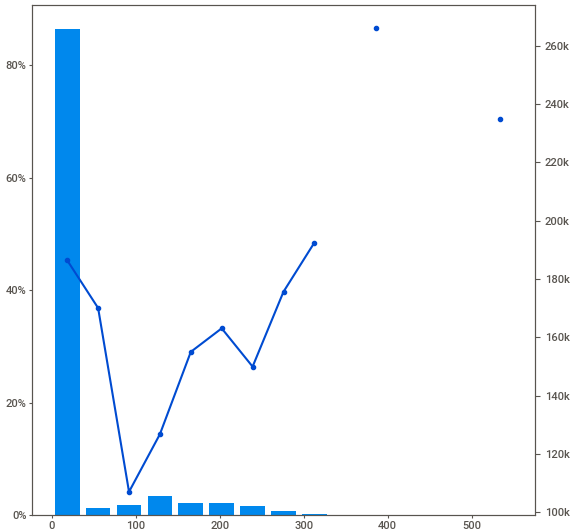
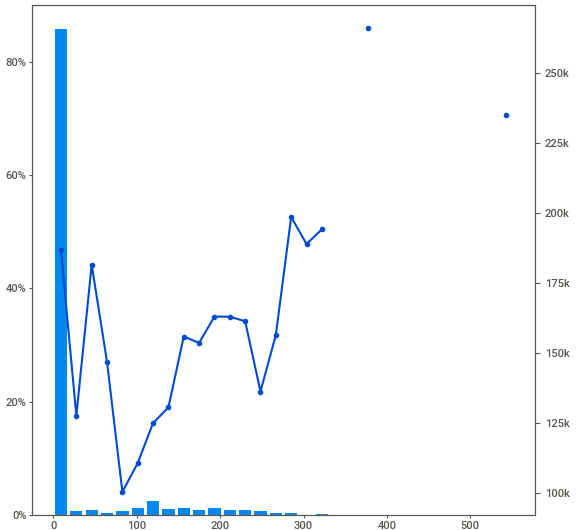
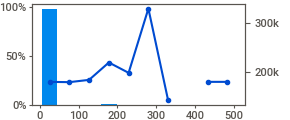
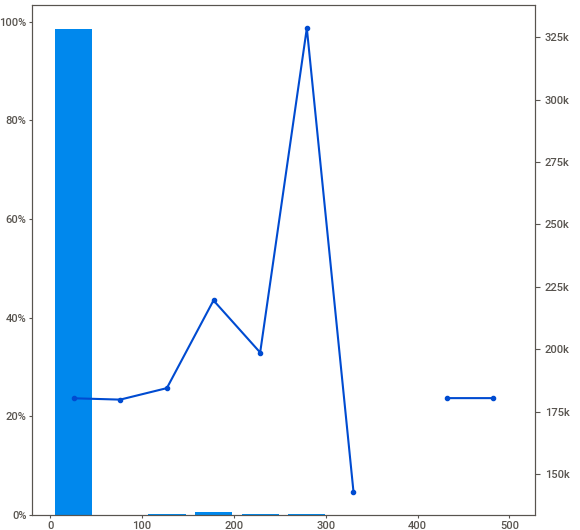
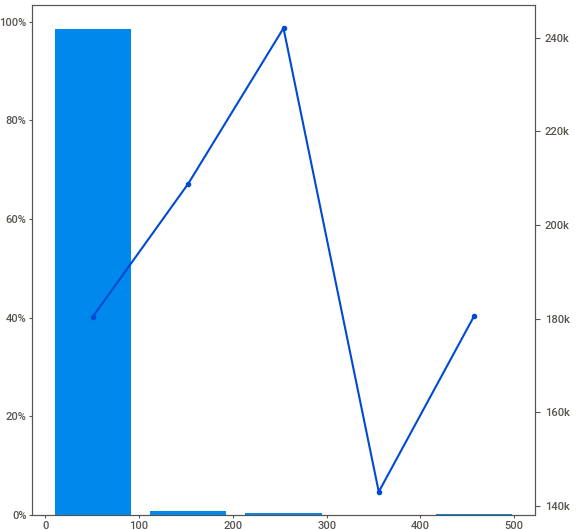
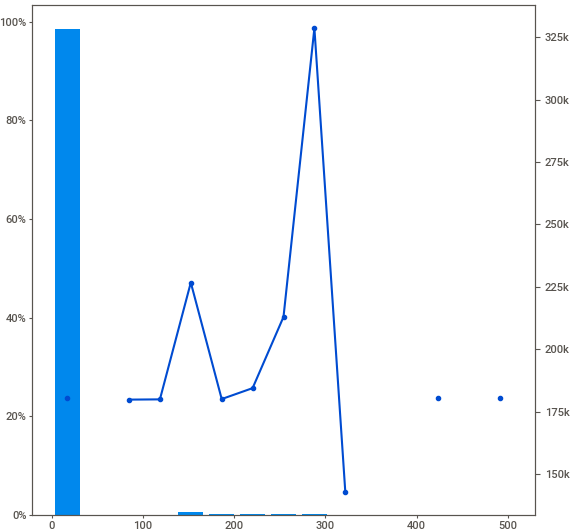
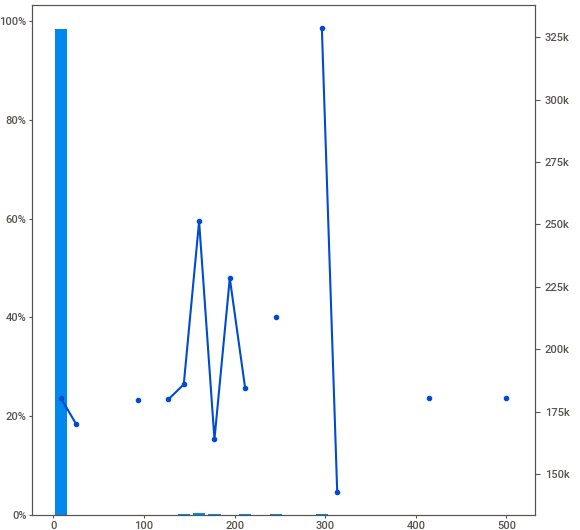
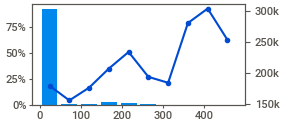
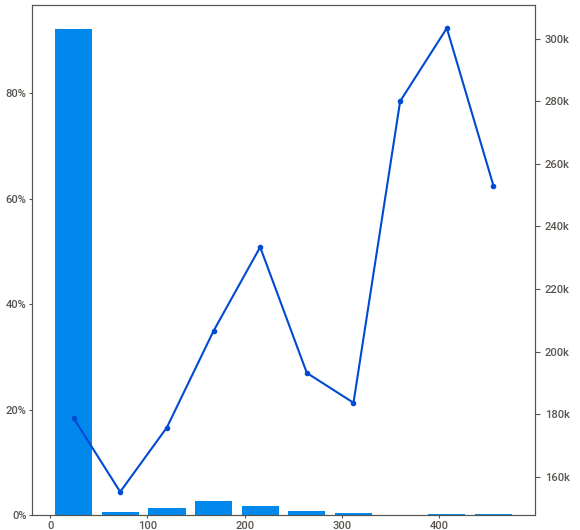
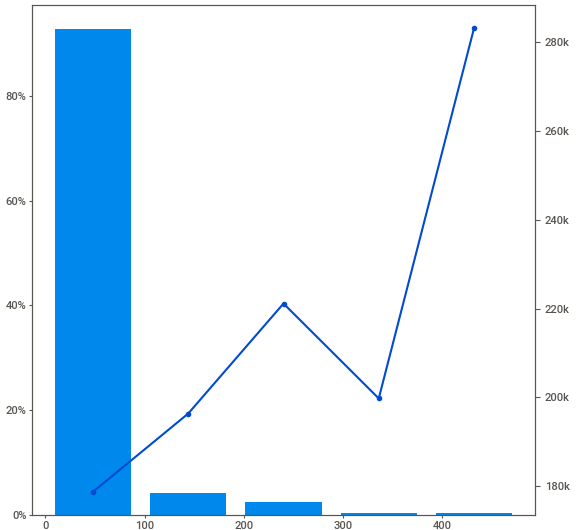
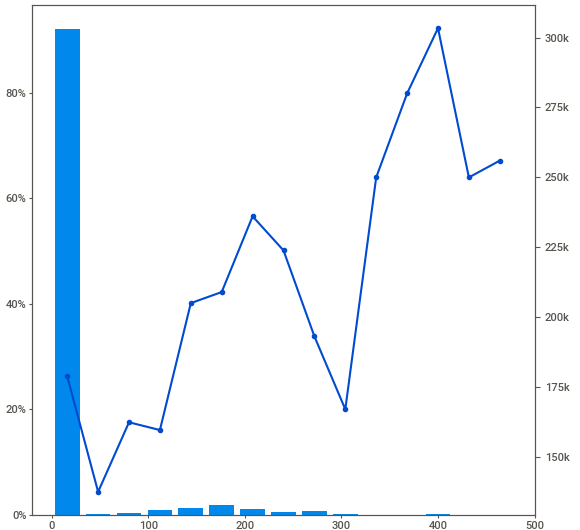
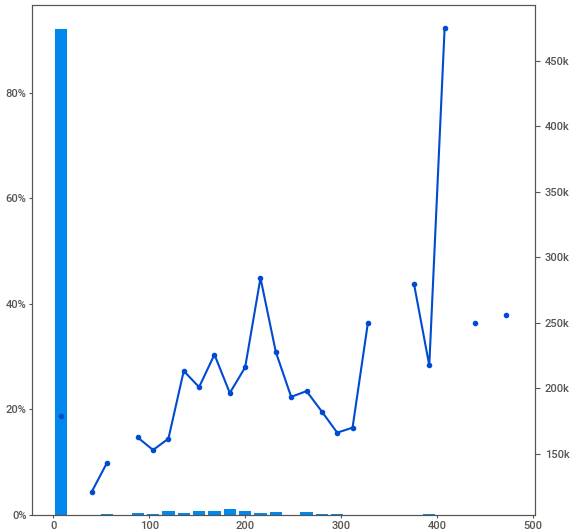
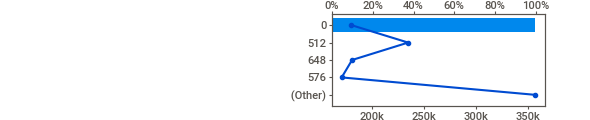
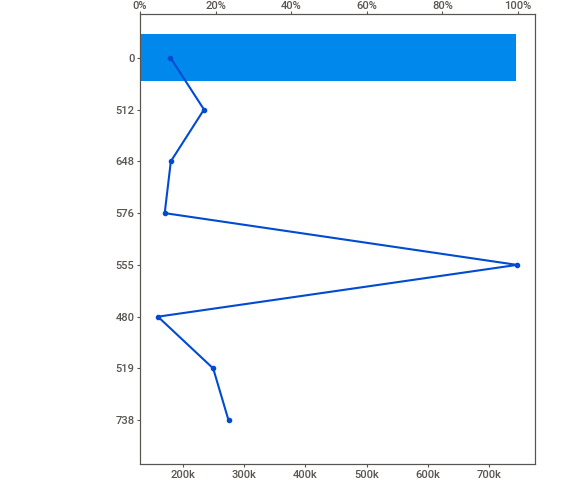
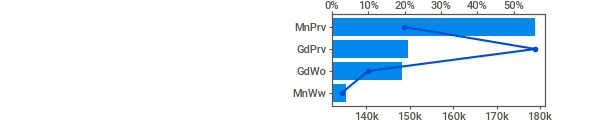
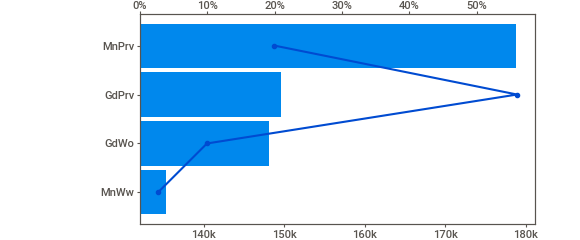
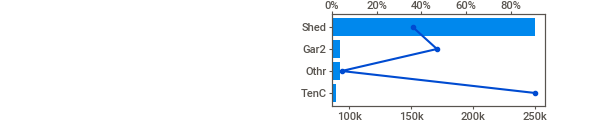
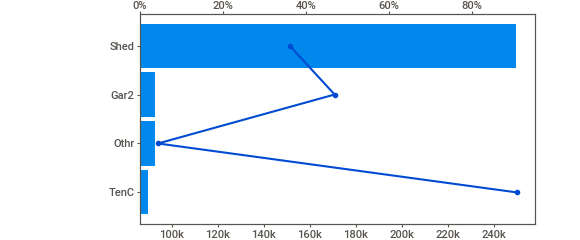
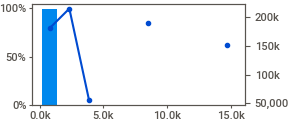
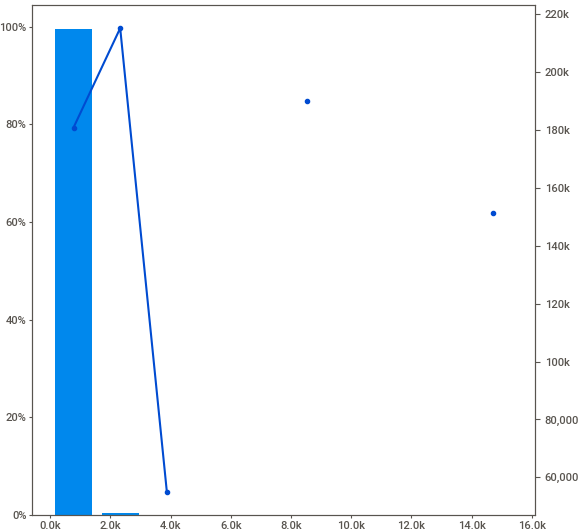
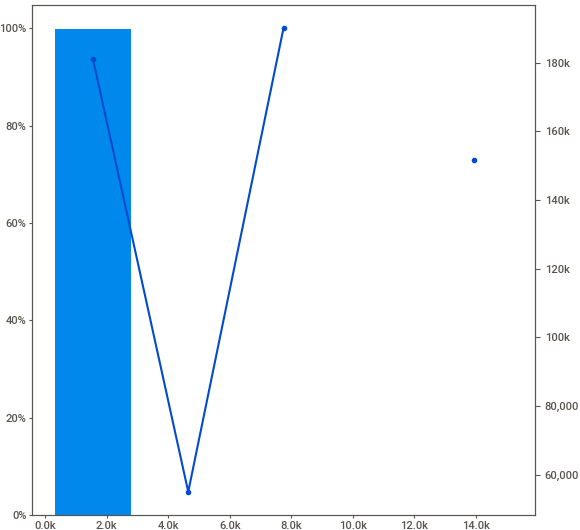
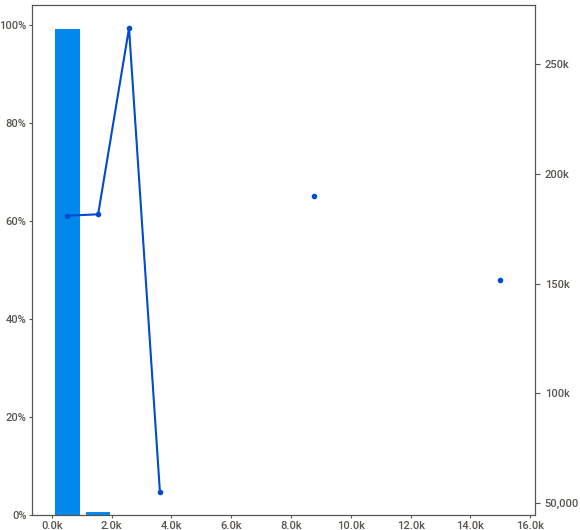
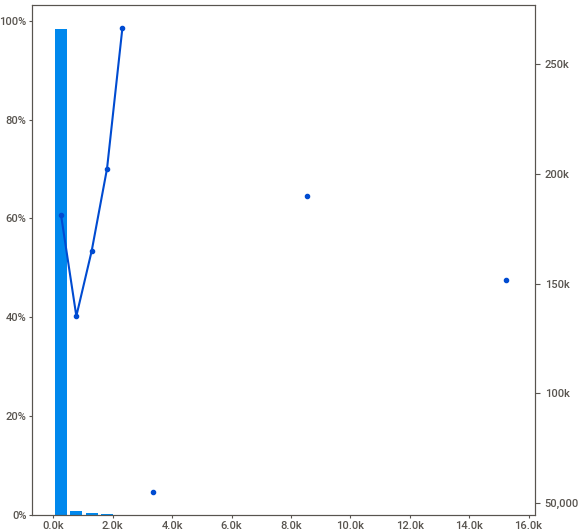
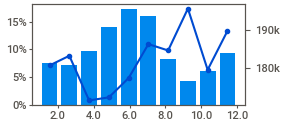
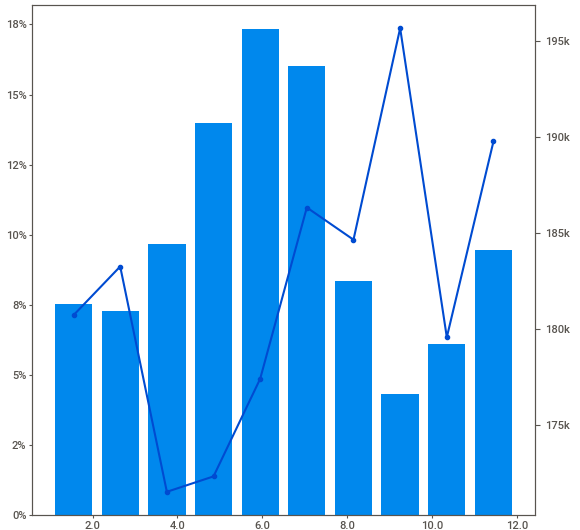
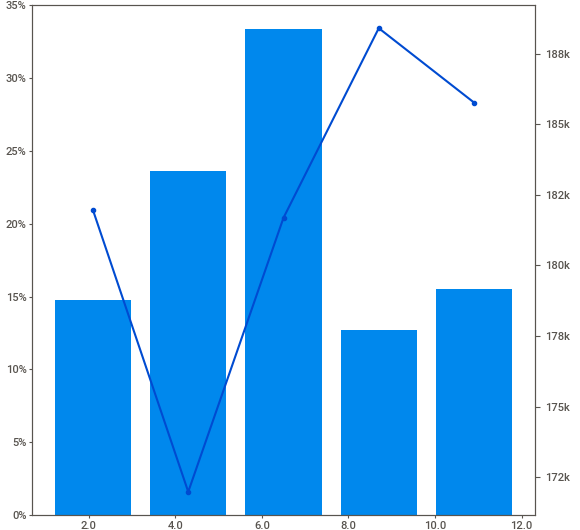
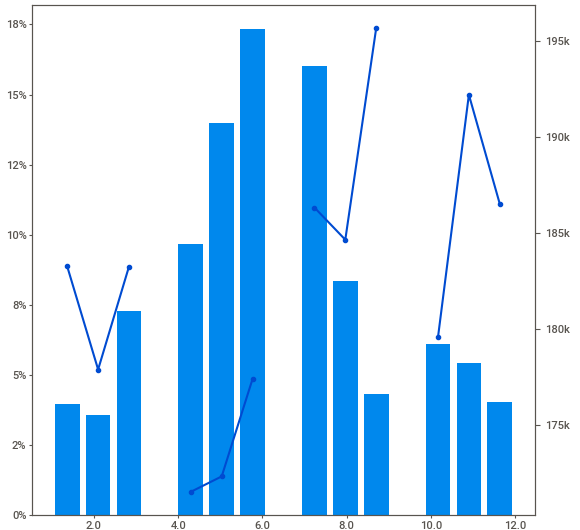
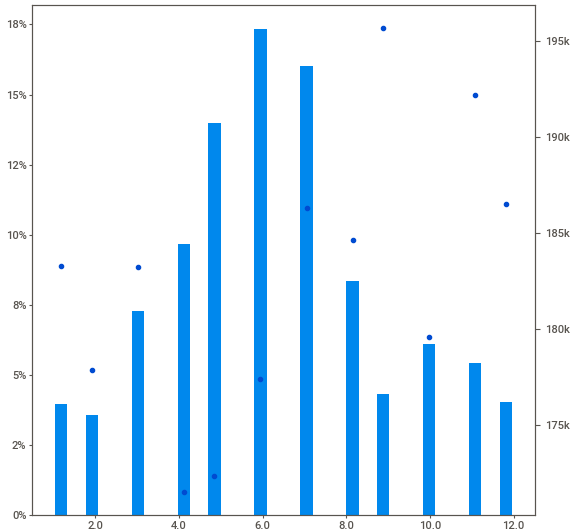
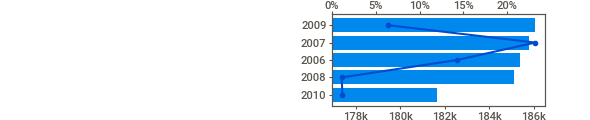
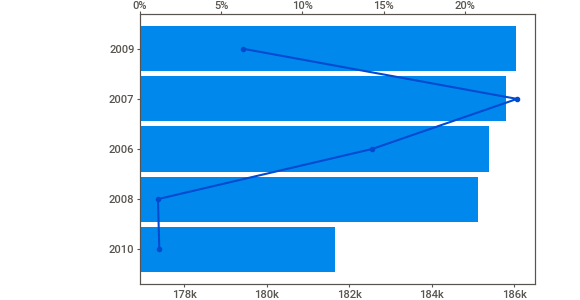
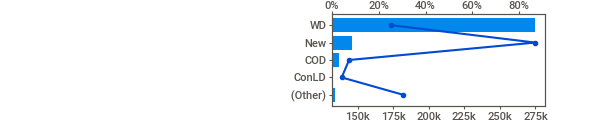
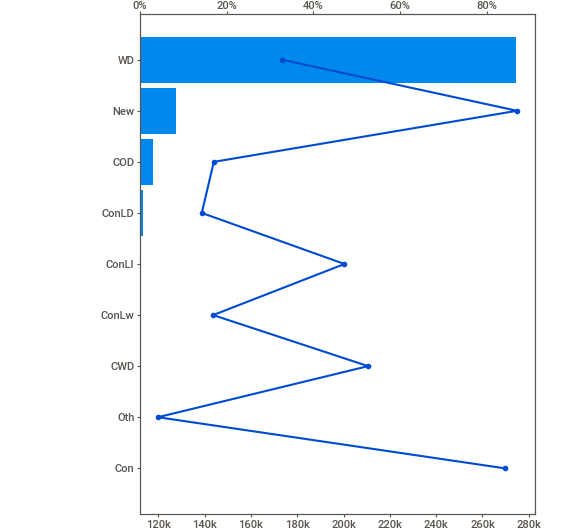
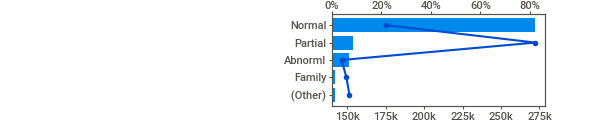
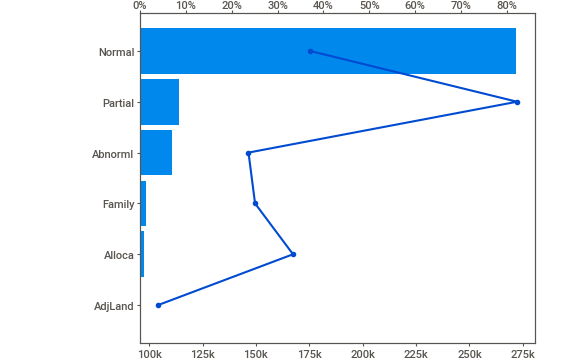
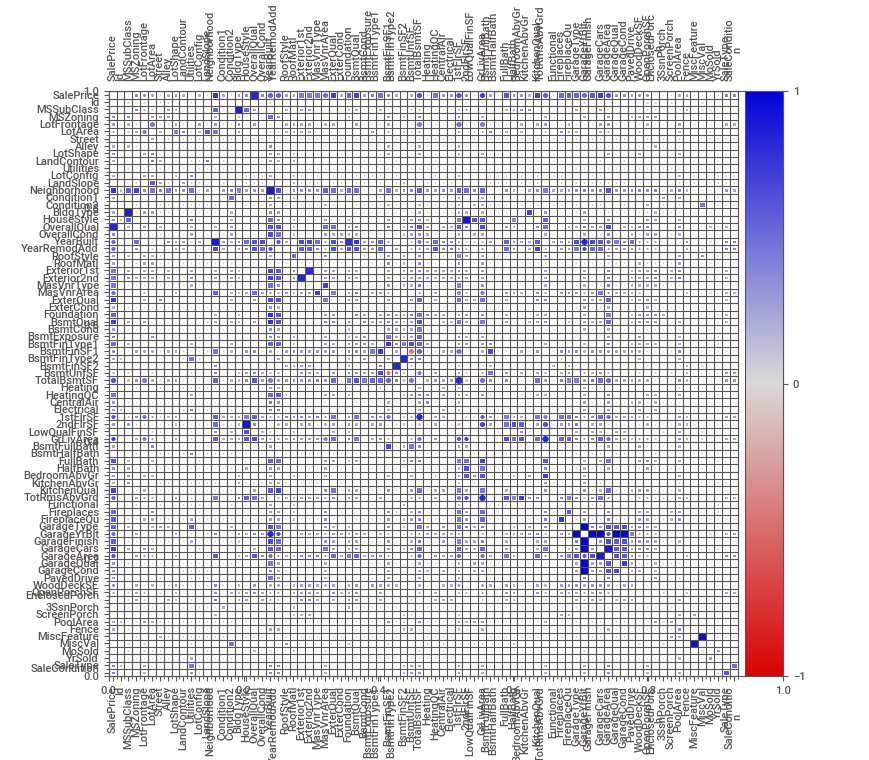
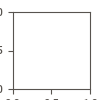

In [ ]:
#report.show_notebook()


### Interpretación (A) — mínimo 10 líneas
Escribe aquí tus hallazgos del EDA, con foco en **tres columnas** específicas y su relación con `SalePrice`.


### 1. `MSZoning` (categórica)

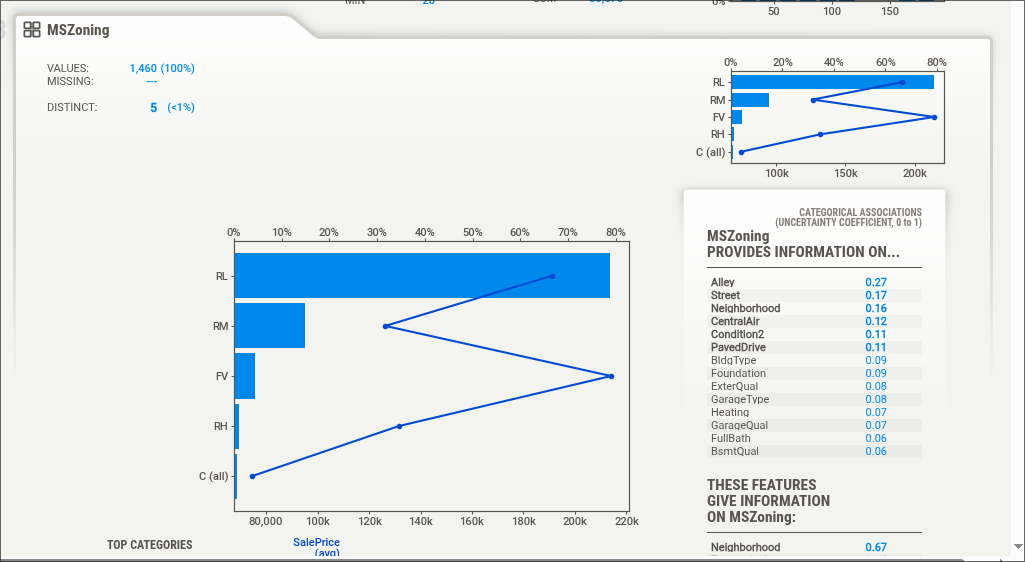

Representa la zonificación general de la propiedad. La mayoría de las propiedades (~94%) están en zonas residenciales (RL, RM,) con ~79% RL y ~15% RM. Otros usos de suelo son menos comunes, sin embargo destaca que el `SalesPrice` medio de estas dos zonas es diferente, siendo casi un 70% mas alto en RL.

## 2. `YearRemodAdd` (numérica) 

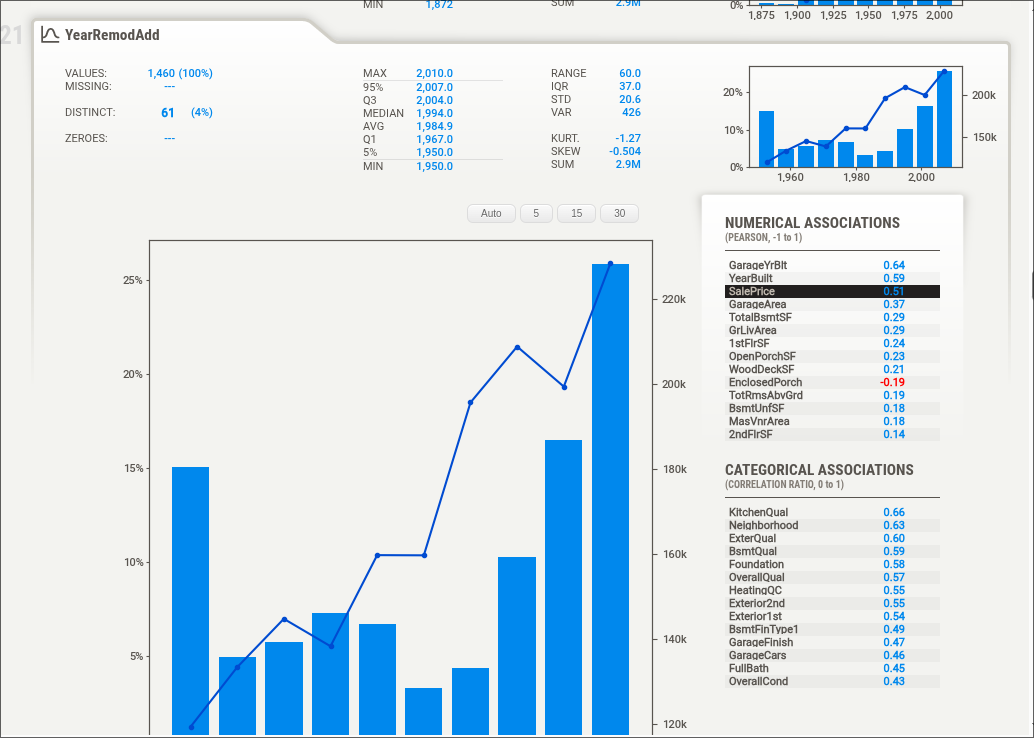

Representa el año de la última remodelación de la vivienda No hay valores faltantes en esta columna. La relación con `SalePrice` muestra que las viviendas remodeladas más recientemente tienden a tener precios de venta más altos, lo cual es lógico ya que las remodelaciones suelen aumentar el valor de una propiedad.

## 3 `MasVnrType` (categórica)

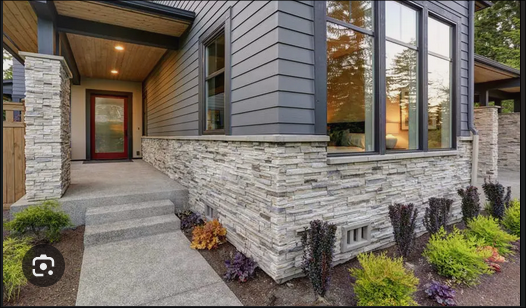


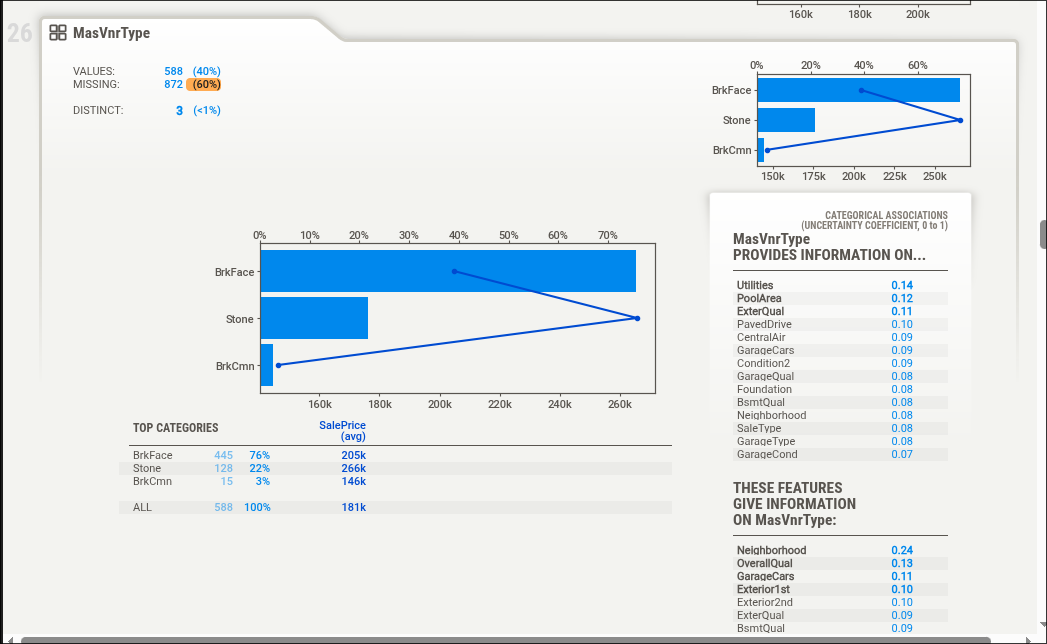

Representa el tipo de revestimiento de la vivienda. Un porcentaje significativo de propiedades carece de revestimiento (~60%) y el mas comun es Brick Face al igual que en `Alley` los valores faltantes son informativos (MNAR) y se interpretan como falta de un recubrimiento de muros. 


/tmp/ipykernel_993055/663655706.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


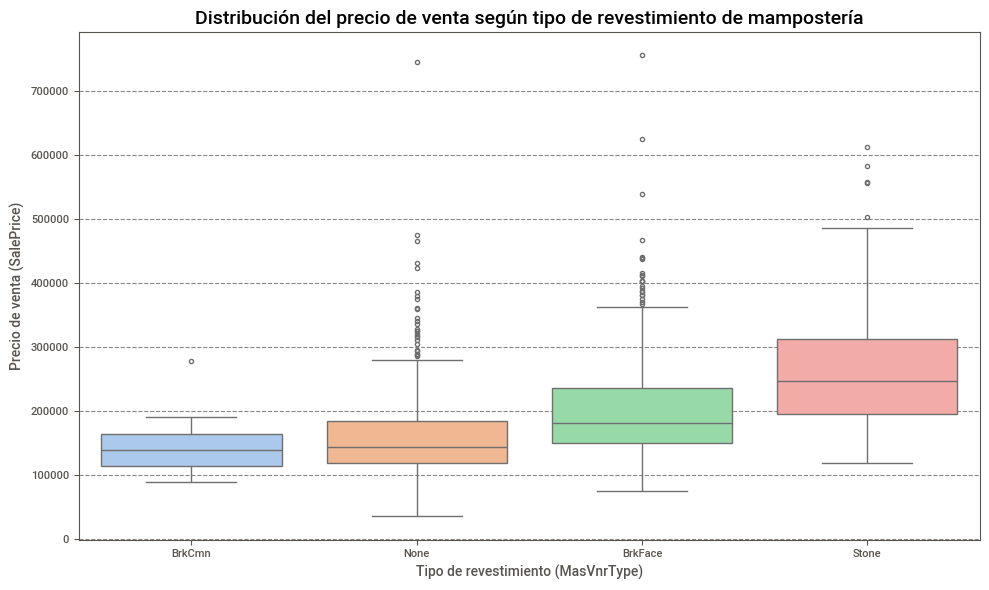

In [ ]:
import seaborn as sns

df_works = df.copy()

# Rellenar valores faltantes de tipo de revestimiento
df_works['MasVnrType'] = df_works['MasVnrType'].fillna('None')

# Ordenar categorías por precio medio
order = (
    df_works.groupby('MasVnrType')['SalePrice']
    .median()
    .sort_values()
    .index
)

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='MasVnrType', 
    y='SalePrice', 
    data=df_works, 
    order=order, 
    palette='pastel'
)
plt.title('Distribución del precio de venta según tipo de revestimiento de mampostería', fontsize=14)
plt.xlabel('Tipo de revestimiento (MasVnrType)')
plt.ylabel('Precio de venta (SalePrice)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Las propiedades con revestimiento de stone suelen tener precios de venta más altos, lo que sugiere que este tipo de revestimiento puede agregar valor a la propiedad.


# Parte B — Preprocesamiento, Modelado y Optimización (15 pts)

## B-1) Pipeline de preprocesamiento (5 pts)
- Usa `ColumnTransformer` + `Pipeline` para imputar faltantes, escalar numéricas y codificar categóricas.
- División 70/30.
- Documenta **cada paso** con comentarios que justifiquen tus decisiones (imputador, escalado, categorías raras, etc.).


In [24]:
# ============================
# Parte B — Preprocesamiento, Modelado y Optimización (15 pts)
# ============================

## B-1) Pipeline de preprocesamiento (5 pts)
# --------------------------------------------
# Objetivo:
# - Construir un pipeline reproducible que limpie, transforme y prepare los datos
# - Justificar cada decisión de imputación, escalado y codificación
# --------------------------------------------

# import pandas as pd
# import numpy as np

# from sklearn.model_selection import train_test_split
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.impute import SimpleImputer
# from sklearn.ensemble import RandomForestRegressor  # Puedes cambiarlo por otro modelo

# =========================================
# 1️⃣ División de datos (train/test 70/30)
# =========================================
X = df.drop(['SalePrice', 'Id'], axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42 
)

# =========================================
# 2️⃣ Identificar columnas por tipo
# =========================================
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()


In [34]:
# -*- coding: utf-8 -*-
"""
Pipeline tabular funcional con:
- Preprocesamiento (imputación num/cat, escala, OHE) con caché toplevel
- Baselines: ElasticNet y RandomForest
- Tuning: XGBoost (Optuna TPE + MedianPruner) con early stopping y pruning
- Paralelismo entre trials (sin nested parallelism)
- Persistencia de métricas e historia de trials en /out
Paradigma funcional: funciones puras + main().
"""

import os
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

import pathlib
import inspect
import multiprocessing as mp
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
import xgboost as xgb
from xgboost import XGBRegressor

from joblib import Memory

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold

DEFAULT_N_ESTIMATORS = 512
DEFAULT_TUNING_TRIALS = 8
DEFAULT_TUNING_WORKERS = 1
DEFAULT_TUNING_STARTUP = 3


# -----------------------------
# Utilidades funcionales
# -----------------------------

def ensure_out_dirs(base: str = "out") -> Dict[str, pathlib.Path]:
    p = pathlib.Path(base)
    p.mkdir(parents=True, exist_ok=True)
    (p / "sk_cache").mkdir(parents=True, exist_ok=True)
    return {"out": p, "cache": p / "sk_cache"}


def split_data(
    df: pd.DataFrame,
    target: str,
    test_size: float = 0.2,
    random_state: int = 42,
    stratify: bool = False
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    y = df[target]
    X = df.drop(columns=[target])
    strat = y if stratify else None
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=strat)


def infer_feature_types(
    X: pd.DataFrame,
    numeric_features: Optional[List[str]] = None,
    categorical_features: Optional[List[str]] = None
) -> Tuple[List[str], List[str]]:
    if numeric_features is None:
        numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
    if categorical_features is None:
        categorical_features = X.select_dtypes(exclude=["number"]).columns.tolist()
    return numeric_features, categorical_features


def build_preprocess(
    numeric_features: List[str],
    categorical_features: List[str],
    cache_dir: pathlib.Path
) -> Tuple[ColumnTransformer, Memory]:
    # Caché solo en el Pipeline toplevel (no en sub-pipelines)
    numeric_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=0.01))
    ])

    preprocess = ColumnTransformer([
        ("num", numeric_pipe, numeric_features),
        ("cat", categorical_pipe, categorical_features)
    ])

    memory = Memory(location=str(cache_dir), verbose=0)
    return preprocess, memory


def rmse(y_true, y_pred) -> float:
    # 100% agnóstico de la versión de sklearn
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))


def evaluate_pipeline(pipe: Pipeline, X_test: pd.DataFrame, y_test: pd.Series) -> Dict[str, float]:
    preds = pipe.predict(X_test)
    return {
        "RMSE": rmse(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds),
        "R2": r2_score(y_test, preds)
    }


def build_fit_params(eval_set, early_rounds):
    """Build fit kwargs compatible con la versión instalada de XGBoost."""
    fit_signature = inspect.signature(XGBRegressor().fit).parameters
    params = {}
    if "verbose" in fit_signature:
        params["regressor__verbose"] = False
    if "early_stopping_rounds" in fit_signature:
        params["regressor__early_stopping_rounds"] = early_rounds
    elif "callbacks" in fit_signature:
        callback = xgb.callback.EarlyStopping(
            rounds=early_rounds,
            metric_name="rmse",
            data_name="validation_0",
            save_best=True
        )
        params["regressor__callbacks"] = [callback]
    return params


def build_baselines(preprocess: ColumnTransformer, memory: Memory) -> Dict[str, Pipeline]:
    elastic = Pipeline([
        ("preprocess", preprocess),
        ("regressor", ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=50000, random_state=42))
    ], memory=memory)

    rf = Pipeline([
        ("preprocess", preprocess),
        ("regressor", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=1))
    ], memory=memory)

    return {"ElasticNet": elastic, "RandomForest": rf}


# -----------------------------
# Optuna + XGBoost
# -----------------------------

def make_objective(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    preprocess: ColumnTransformer,
    memory: Memory,
    n_splits: int = 5,
    early_rounds: int = 100,
    random_state: int = 42
):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    def objective(trial: optuna.Trial) -> float:
        params = {
            "n_estimators": DEFAULT_N_ESTIMATORS,
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 3e-1, log=True),
            "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 10.0, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        }

        model = Pipeline([
            ("preprocess", preprocess),
            ("regressor", XGBRegressor(
                objective="reg:squarederror",
                tree_method="hist",
                device="cpu",
                n_jobs=1,
                eval_metric="rmse",
                random_state=random_state,
                **params
            ))
        ], memory=memory)

        fold_scores = []
        for fold_idx, (tr_idx, va_idx) in enumerate(cv.split(X_train, y_train), start=1):
            X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
            y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

            fit_params = build_fit_params([(X_va, y_va)], early_rounds)
            model.fit(
                X_tr, y_tr,
                **fit_params
            )

            preds = model.predict(X_va)
            s = rmse(y_va, preds)
            fold_scores.append(s)

            trial.report(float(np.mean(fold_scores)), step=fold_idx)
            if trial.should_prune():
                raise optuna.TrialPruned()

        return float(np.mean(fold_scores))

    return objective


def run_study(
    objective,
    storage_url: str,
    study_name: str = "xgb_opt",
    n_trials: int = DEFAULT_TUNING_TRIALS,
    n_workers_cap: int = DEFAULT_TUNING_WORKERS,
    startup_trials: int = DEFAULT_TUNING_STARTUP,
    seed: int = 42
) -> optuna.Study:
    startup_trials = max(1, min(startup_trials, n_trials))
    sampler = TPESampler(
        multivariate=True,
        group=True,
        n_startup_trials=startup_trials,
        constant_liar=True,
        seed=seed
    )
    pruner = MedianPruner(n_startup_trials=max(1, min(10, n_trials // 2)), n_warmup_steps=0)

    study = optuna.create_study(
        direction="minimize",
        study_name=study_name,
        storage=storage_url,
        load_if_exists=True,
        sampler=sampler,
        pruner=pruner
    )

    n_workers = min(n_workers_cap, n_trials, max(1, mp.cpu_count() - 1))
    study.optimize(objective, n_trials=n_trials, n_jobs=n_workers, gc_after_trial=True)
    return study


def train_best_model(
    study: optuna.Study,
    X_train: pd.DataFrame, y_train: pd.Series,
    X_test: pd.DataFrame, y_test: pd.Series,
    preprocess: ColumnTransformer, memory: Memory,
    early_rounds: int = 200,
    random_state: int = 42
) -> Tuple[Pipeline, Dict[str, float]]:
    best_params = {**study.best_trial.params, "n_estimators": DEFAULT_N_ESTIMATORS}

    best_pipe = Pipeline([
        ("preprocess", preprocess),
        ("regressor", XGBRegressor(
            objective="reg:squarederror",
            tree_method="hist",
            device="cuda",
            n_jobs=1,
            eval_metric="rmse",
            random_state=random_state,
            **best_params
        ))
    ], memory=memory)

    fit_params = build_fit_params([(X_test, y_test)], early_rounds)
    best_pipe.fit(
        X_train, y_train,
        **fit_params
    )

    metrics = evaluate_pipeline(best_pipe, X_test, y_test)
    return best_pipe, metrics


# -----------------------------
# Persistencia
# -----------------------------

def save_baselines_metrics(
    baselines: Dict[str, Pipeline],
    X_train: pd.DataFrame, y_train: pd.Series,
    X_test: pd.DataFrame, y_test: pd.Series,
    out_dir: pathlib.Path
) -> pd.DataFrame:
    rows = []
    for name, pipe in baselines.items():
        pipe.fit(X_train, y_train)
        m = evaluate_pipeline(pipe, X_test, y_test)
        rows.append({"model": name, **m})
    df = pd.DataFrame(rows)
    df.to_csv(out_dir / "partB_metrics_baseline.csv", index=False)
    return df


def save_rf_importances(
    rf_pipe: Pipeline,
    numeric_features: List[str],
    categorical_features: List[str],
    out_dir: pathlib.Path,
    topk: int = 30
) -> None:
    # Extrae nombres de features tras OHE (si existen cat)
    pre = rf_pipe.named_steps["preprocess"]
    feature_names = list(numeric_features)
    if "cat" in pre.named_transformers_ and len(categorical_features) > 0:
        enc = pre.named_transformers_["cat"].named_steps["encoder"]
        cat_names = enc.get_feature_names_out(categorical_features)
        feature_names = np.concatenate([numeric_features, cat_names])

    importances = rf_pipe.named_steps["regressor"].feature_importances_
    pd.Series(importances, index=feature_names).sort_values(ascending=False).head(topk)\
        .to_csv(out_dir / "partB_rf_feature_importance.csv")


def save_study_history(study: optuna.Study, out_dir: pathlib.Path, fname: str) -> None:
    study.trials_dataframe().to_csv(out_dir / fname, index=False)


def save_comparison(
    baseline_df: pd.DataFrame,
    tuned_metrics: Dict[str, float],
    out_dir: pathlib.Path,
    tuned_label: str = "XGB_tuned"
) -> pd.DataFrame:
    rf_row = baseline_df.loc[baseline_df["model"] == "RandomForest"].iloc[0]
    comp = pd.DataFrame({
        "metric": ["RMSE", "MAE", "R2"],
        "baseline_RF": [rf_row["RMSE"], rf_row["MAE"], rf_row["R2"]],
        tuned_label: [tuned_metrics["RMSE"], tuned_metrics["MAE"], tuned_metrics["R2"]]
    })
    comp.to_csv(out_dir / "partB_model_comparison.csv", index=False)
    return comp


# -----------------------------
# main(): ejemplo de uso
# -----------------------------

def main(
    df: pd.DataFrame,
    target: str,
    numeric_features: Optional[List[str]] = None,
    categorical_features: Optional[List[str]] = None,
    test_size: float = 0.2,
    storage_url: str = "sqlite:///out/partB_optuna.db",
    n_splits_cv: int = 5
) -> Dict[str, object]:
    paths = ensure_out_dirs("out")

    X_train, X_test, y_train, y_test = split_data(df, target, test_size=test_size, random_state=42)
    numeric_features, categorical_features = infer_feature_types(X_train, numeric_features, categorical_features)

    preprocess, memory = build_preprocess(numeric_features, categorical_features, paths["cache"])

    # Baselines
    baselines = build_baselines(preprocess, memory)
    baseline_df = save_baselines_metrics(baselines, X_train, y_train, X_test, y_test, paths["out"])

    # Guardar importancias de RF baseline (opcional)
    save_rf_importances(baselines["RandomForest"], numeric_features, categorical_features, paths["out"], topk=30)

    # Optuna XGB tuning
    objective = make_objective(
        X_train=X_train, y_train=y_train,
        preprocess=preprocess, memory=memory,
        n_splits=n_splits_cv, early_rounds=100, random_state=42
    )
    study = run_study(
        objective=objective,
        storage_url=storage_url,
        study_name="xgb_opt",
        n_trials=DEFAULT_TUNING_TRIALS,
        n_workers_cap=DEFAULT_TUNING_WORKERS,
        startup_trials=DEFAULT_TUNING_STARTUP,
        seed=42
    )
    save_study_history(study, paths["out"], "partB_optuna_trials_xgb.csv")

    # Entrenar mejor modelo y evaluar
    best_model, tuned_metrics = train_best_model(
        study, X_train, y_train, X_test, y_test,
        preprocess, memory, early_rounds=200, random_state=42
    )

    comparison_df = save_comparison(baseline_df, tuned_metrics, paths["out"], tuned_label="XGB_tuned")

    return {
        "paths": paths,
        "numeric_features": numeric_features,
        "categorical_features": categorical_features,
        "baseline_metrics": baseline_df,
        "tuned_metrics": tuned_metrics,
        "comparison": comparison_df,
        "study": study,
        "best_model": best_model
    }



## B-2) Dos modelos de regresión (5 pts)
Entrena **dos modelos distintos** y compara su rendimiento.  
Métricas obligatorias: **RMSE**, **MAE**, **R²**.  
Incluye comentarios justificando la elección de cada modelo y su sensibilidad a los pasos de preprocesamiento.


In [35]:
#df = pd.read_csv("data.csv")
result = main(df, target="SalePrice")

/home/giorgio6846/miniconda3/envs/DMT/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/giorgio6846/miniconda3/envs/DMT/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/giorgio6846/miniconda3/envs/DMT/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-10-21 22:02:55,203] Using an existing study with name 'xgb_gpu_opt' instead of creating a new one.
[W 2025-10-21 22:02:55,704] Trial 20 failed with parameters: {'max_depth': 12, 'learning_rate': 0.003059913241746526, 'min_child_weight': 0.06696323758367252, 'subsample': 0.935348105670662, 'colsample_bytree': 0.96133

TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'


### Interpretación (B-2)
- Compara ambos modelos (2–3 párrafos): sesgo/varianza, efecto del escalado, robustez ante imputación.  
- Para modelos de árboles, discute **importancia de variables** y relación con el dominio inmobiliario.



## B-3) Optimización con Optuna (5 pts)
Optimiza **uno** de los modelos anteriores (ejemplo: RandomForestRegressor) usando **Optuna**.  
Reporta: mejor conjunto de hiperparámetros, evolución del estudio y **discute** el impacto en métricas vs. baseline.



### Interpretación (B-3)
- ¿Qué hiperparámetros resultaron más influyentes y por qué?  
- ¿Cuánto mejora el rendimiento vs. baseline y a qué costo computacional?  
- ¿Cambian tus conclusiones respecto a la elección del modelo?



## Conclusiones generales
Redacta aquí una síntesis que conecte **EDA → preprocesamiento → modelos → optimización**, destacando decisiones clave y lecciones aprendidas.



## 🧾 Rúbrica de Evaluación

| **Criterio** | **Descripción** | **Peso** |
|--------------|-----------------|-----------|
| **Ejecución técnica** | Implementación correcta del EDA, pipeline, modelos y Optuna. | **40%** |
| **Interpretación analítica** | Análisis detallado del EDA, comparación entre modelos, interpretación de métricas e hiperparámetros. | **40%** |
| **Documentación del código** | Comentarios claros, orden lógico y uso adecuado de celdas *Markdown*. | **20%** |

> **Nota:** La evaluación prioriza la coherencia entre el EDA, el preprocesamiento y las decisiones de modelado.
